# Music Genre Classification
Aris Karalis - 36622966

This notebook implements various neural network architectures for classifying music genres using the GTZAN dataset. The models use mel-spectrograms as input features and demonstrate different techniques like fully connected networks, CNNs with and without batch normalization, and LSTM networks.

## Table of Contents

1. Setup and Imports
2. Data Acquisition
3. Spectrogram Generation
4. Data Preparation
5. Data Visualisation
6. Model Architecture 1: Fully Connected Neural Network
7. Model Architecture 2: CNN
8. Model Architecture 3: CNN with Batch Normalisation
9. Model Architecture 4: CNN with Batch Normalisation and RMSprop
10. MFCC Extraction
11. Model Architecture 5: LSTM
12. Architecture of cGAN
13. LSTM Model with cGAN-Generated MFCC Features +Original MFCC Features


## Setup and Imports <a id="setup-and-imports"></a>

Import all necessary libraries and set global constants.

In [74]:
# Standard libraries
import os
import random
import io
from PIL import Image

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Machine learning
from sklearn.metrics import accuracy_score,\
    f1_score, classification_report,\
    confusion_matrix, ConfusionMatrixDisplay
# PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.datasets as datasets

# Experiment tracking
from comet_ml import start
from comet_ml.integration.pytorch import log_model

# For LSTM model
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm import tqdm
import glob
import time
import soundfile as sf

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Global constants
NUM_CLASSES = 10  # 10 music genres
BATCH_SIZE = 32
LEARNING_RATE_DEFAULT = 0.00001
IMAGE_SIZE = 180  # 180x180 for spectrograms

# Setup GPU Device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Data Acquisition <a id="data-acquisition"></a>

Download and extract the GTZAN dataset from Kaggle.

In [75]:
def setup_kaggle():
    """Set up Kaggle credentials for dataset download"""
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle credentials set up successfully.")

def download_dataset():
    """Download the GTZAN dataset from Kaggle"""
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
    print("Dataset downloaded successfully.")

def extract_dataset():
    """Extract the dataset from the zip file"""
    import zipfile
    with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
        zip_ref.extractall('Data')
    print("Dataset extracted successfully.")

def setup_comet(api_key, project_name="MusicGenreClassification", workspace="ariskaralis"):
    """Initialize CometML for experiment tracking"""
    experiment = start(
        api_key=api_key,
        project_name=project_name,
        workspace=workspace
    )
    return experiment

comet_api_key = "yiOG0hwuTZfCFrO1s7eTzxsjW"
# Run setup functions
# setup_kaggle()
# download_dataset()
# extract_dataset()
experiment = setup_comet(api_key=comet_api_key)

COMET INFO: An experiment with the same configuration options is already running and will be reused.


First we will generate the mel-spectrograms from scratch and save them as images so we do not lose any infromation by the conversion to grayscale from RGBA

## Spectrogram Generation <a id="spectrogram-generation"></a>

This section generates mel-spectrograms from the audio files and saves them as grayscale images.

In [76]:
def check_if_spectrograms_exist(wav_path, output_path, tolerance=1):
    """
    Check if spectrograms already exist for audio files, with tolerance for a few missing files.

    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images should be saved
        tolerance (int): Number of files that can be missing per genre (default=1)

    Returns:
        bool: True if spectrograms exist (within tolerance), False otherwise
    """
    # If output directory doesn't exist, spectrograms don't exist
    if not os.path.exists(output_path):
        return False

    # Get list of genres from audio files
    audio_genres = [g for g in os.listdir(wav_path) if os.path.isdir(os.path.join(wav_path, g))]

    # Track total files and mismatches
    total_wav_files = 0
    total_png_files = 0
    total_mismatches = 0

    # Check if each genre folder exists in the output directory and has similar number of files
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)

        # Check if genre folder exists in output directory
        if not os.path.exists(spec_genre_path):
            return False

        # Count number of wav files and png files
        wav_files = [f for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [f for f in os.listdir(spec_genre_path) if f.endswith('.png')]

        wav_count = len(wav_files)
        png_count = len(png_files)

        # Check for mismatches
        difference = wav_count - png_count

        # If the difference is more than the tolerance, regenerate
        if difference > tolerance:
            print(f"Genre {genre}: {wav_count} WAV files but only {png_count} PNG files")
            return False

        # If we have more PNGs than WAVs, something is wrong
        if difference < 0:
            print(f"Genre {genre}: More PNG files ({png_count}) than WAV files ({wav_count})! Might need cleaning.")

        total_wav_files += wav_count
        total_png_files += png_count
        total_mismatches += max(0, difference)  # Only count missing files, not excess

    # Check if total mismatches exceed global tolerance
    if total_mismatches > tolerance * len(audio_genres):
        print(f"Total missing spectrograms: {total_mismatches} (tolerance: {tolerance * len(audio_genres)})")
        return False

    # Check for exact file correspondence, not just counts
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)

        wav_files = [os.path.splitext(f)[0] for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [os.path.splitext(f)[0] for f in os.listdir(spec_genre_path) if f.endswith('.png')]

        # Check if most wav files have corresponding png files
        files_without_spectrograms = [f for f in wav_files if f not in png_files]
        if len(files_without_spectrograms) > tolerance:
            print(f"Genre {genre} has {len(files_without_spectrograms)} WAV files without spectrograms")
            return False

    print(f"Spectrograms exist: {total_png_files} spectrograms for {total_wav_files} WAV files")
    return True

def create_mel_spectrogram(file_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Create mel spectrogram from an audio file.

    Args:
        file_path (str): Path to the audio file
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands

    Returns:
        tuple: (S_dB, sr) - log-scaled mel spectrogram and sample rate
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Generate mel-spectrogram
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels)

    # Convert to log scale (dB)
    S_dB = librosa.power_to_db(S, ref=np.max)

    return S_dB, sr


def save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size=180):
    """
    Save a spectrogram as a grayscale image.

    Args:
        S_dB (numpy.ndarray): Log-scaled mel spectrogram
        sr (int): Sample rate
        hop_length (int): Number of samples between successive frames
        output_file_path (str): Path where to save the image
        image_size (int): Size of output image (square)

    Returns:
        bool: True if the image was saved successfully
    """
    try:
        # Plot spectrogram
        plt.figure(figsize=(3, 3), dpi=60)
        librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, cmap='gray_r')
        plt.axis('off')  # Remove axis

        # Save image into buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()

        # Load from buffer, resize, and save
        buf.seek(0)
        image = Image.open(buf).convert('L')  # Convert to grayscale ('L' mode)
        image = image.resize((image_size, image_size), Image.Resampling.LANCZOS)

        # Save final image
        image.save(output_file_path)
        return True

    except Exception as e:
        print(f"Error saving spectrogram to {output_file_path}: {str(e)}")
        return False


def process_genre_folder(genre_path, output_genre_path, n_fft=2048, hop_length=512, n_mels=128, image_size=180):
    """
    Process all audio files in a genre folder and create spectrograms.

    Args:
        genre_path (str): Path to the genre folder containing WAV files
        output_genre_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands
        image_size (int): Size of output images

    Returns:
        tuple: (processed_count, error_count) - number of files processed and errors
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_genre_path, exist_ok=True)

    processed_count = 0
    error_count = 0

    for file in os.listdir(genre_path):
        if not file.endswith('.wav'):
            continue

        file_path = os.path.join(genre_path, file)
        image_filename = os.path.splitext(file)[0] + '.png'
        output_file_path = os.path.join(output_genre_path, image_filename)

        # Skip if this specific file already exists
        if os.path.exists(output_file_path):
            continue

        try:
            # Create mel spectrogram
            S_dB, sr = create_mel_spectrogram(file_path, n_fft, hop_length, n_mels)

            # Save spectrogram as image
            if save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size):
                processed_count += 1
                print(f"Saved spectrogram for {file_path} as {image_filename}")
            else:
                error_count += 1

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            error_count += 1

    return processed_count, error_count


def generate_spectrograms(wav_path, output_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Generate mel-spectrograms from audio files and save them as grayscale images.

    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands

    Returns:
        bool: True if spectrograms were generated, False if they already existed
    """
    # Check if spectrograms already exist
    if check_if_spectrograms_exist(wav_path, output_path):
        print("Spectrogram images already exist. Skipping generation.")
        return False

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    print("Generating mel-spectrograms...")
    genres = os.listdir(wav_path)

    total_processed = 0
    total_errors = 0

    for genre in genres:
        genre_path = os.path.join(wav_path, genre)

        if not os.path.isdir(genre_path):
            continue

        output_genre_path = os.path.join(output_path, genre)

        # Process all files in the genre folder
        processed, errors = process_genre_folder(
            genre_path,
            output_genre_path,
            n_fft,
            hop_length,
            n_mels,
            IMAGE_SIZE
        )

        total_processed += processed
        total_errors += errors

    print(f"Spectrogram generation complete. Generated {total_processed} spectrograms with {total_errors} errors.")
    return True

In [77]:
print(device)

mps


In [78]:
# Define paths for dataset
wav_dataset_path = ''
spectrogram_path = ''
if str(device) == 'mps':
  wav_dataset_path = 'Data/genres_original'
  spectrogram_path = 'Data/greyscale_spectrograms'
elif str(device) == 'cuda':
  wav_dataset_path = '/content/drive/MyDrive/DLT/Data/genres_original'
  spectrogram_path = '/content/drive/MyDrive/DLT/Data/greyscale_spectrograms'

# Generate spectrograms if needed
spectrograms_generated = generate_spectrograms(
    wav_path=wav_dataset_path,
    output_path=spectrogram_path,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

Spectrograms exist: 999 spectrograms for 1000 WAV files
Spectrogram images already exist. Skipping generation.


## Data Preparation <a id="data-preparation"></a>

This section prepares the data by splitting it into training, validation, and test sets, and creating appropriate data transformations.

In [79]:
def calculate_dataset_statistics(root_dir, indices=None):
    """
    Calculate the mean and standard deviation of the dataset.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        indices (list): Optional indices to use for calculation (for using only training data)

    Returns:
        tuple: (mean, std) of the dataset
    """
    temp_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    # Load dataset with minimal transformations
    temp_dataset = datasets.ImageFolder(root=root_dir, transform=temp_transform)

    # Create subset if indices provided
    if indices is not None:
        dataset_for_stats = Subset(temp_dataset, indices)
    else:
        dataset_for_stats = temp_dataset

    loader = DataLoader(dataset_for_stats, batch_size=32, shuffle=False)

    # Calculate statistics
    sum_pixels = 0.0
    sum_sq_pixels = 0.0
    total_pixels = 0

    for images, _ in loader:
        sum_pixels += images.sum().item()
        sum_sq_pixels += (images ** 2).sum().item()
        total_pixels += images.numel()

    mean = sum_pixels / total_pixels
    var = (sum_sq_pixels / total_pixels) - (mean ** 2)
    std = var ** 0.5

    print(f"Dataset Statistics - Mean: {mean:.4f}, Std: {std:.4f}")
    return mean, std

def create_data_transforms(mean, std):
    """
    Create data transformations for training, validation, and test sets.

    Args:
        mean (float): Mean of the dataset
        std (float): Standard deviation of the dataset

    Returns:
        dict: Dictionary containing transformations for each split
    """
    transform_train = transforms.Compose([
        # Crop random region of the image
        transforms.RandomApply([
            transforms.RandomCrop((80, 80))],
            p=0.1
        ),

        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

        # Convert to tensor
        transforms.ToTensor(),

        # Randomly affine images
        transforms.RandomApply([transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0),
            fill=0)],
            p=0.1
        ),

        # Randomly erase image parts
        transforms.RandomErasing(
            p=0.5,
            scale=(0.004, 0.02),    # ~0.4% to 2% of the total area
            ratio=(20, 200)         # tall/narrow rectangles
        ),

        # Normalise images with calculated mean and std
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_val = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return {
        'train': transform_train,
        'val': transform_val,
        'test': transform_test
    }

def custom_gray_loader(path: str):
    """Load an image as grayscale"""
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

def create_dataloaders(root_dir, transforms_dict, indices_dict, batch_size=32):
    """
    Create dataloaders for training, validation, and test sets.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        transforms_dict (dict): Dictionary containing transformations for each split
        indices_dict (dict): Dictionary containing indices for each split
        batch_size (int): Batch size for the dataloaders

    Returns:
        dict: Dictionary containing dataloaders for each split
    """
    datasets_dict = {}
    dataloaders = {}

    for split in ['train', 'val', 'test']:
        # Create the full dataset with appropriate transform
        full_dataset = datasets.ImageFolder(
            root=root_dir,
            transform=transforms_dict[split],
            loader=custom_gray_loader
        )

        # Create the subset with appropriate indices
        datasets_dict[split] = Subset(full_dataset, indices_dict[split])

        # Create the dataloader with appropriate parameters
        dataloaders[split] = DataLoader(
            datasets_dict[split],
            batch_size=batch_size,
            shuffle=(split == 'train'),  # Only shuffle training data
        )

    return dataloaders

# Main data preparation execution
def prepare_data(root_dir, seed=10, batch_size=32):
    """
    Main function to prepare data for training, validation, and testing.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        seed (int): Random seed for reproducibility
        batch_size (int): Batch size for the dataloaders

    Returns:
        tuple: (dataloaders, mean, std)
    """
    dataset_wout_transform = datasets.ImageFolder(root=root_dir, transform=None)

    # Split the dataset into 70% training, 20% validation and 10% test sets
    n_total = len(dataset_wout_transform)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val

    indices = list(range(n_total))
    train_subset_indices, val_subset_indices, test_subset_indices = torch.utils.data.random_split(
        indices,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(seed)
    )

    print(f"Dataset split - Total: {n_total}, Training: {n_train}, Validation: {n_val}, Test: {n_test}")

    # Calculate dataset statistics using training set only
    mean, std = calculate_dataset_statistics(root_dir, train_subset_indices.indices)

    # Create data transforms
    transforms_dict = create_data_transforms(mean, std)

    # Create indices dictionary
    indices_dict = {
        'train': train_subset_indices.indices,
        'val': val_subset_indices.indices,
        'test': test_subset_indices.indices
    }

    # Create dataloaders
    dataloaders = create_dataloaders(spectrogram_path, transforms_dict, indices_dict, batch_size)

    return dataloaders, mean, std

# Execute data preparation

dataloaders, mean, std = prepare_data(spectrogram_path, seed=10, batch_size=BATCH_SIZE)

# Extract individual loaders for convenience
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

Dataset split - Total: 999, Training: 699, Validation: 199, Test: 101
Dataset Statistics - Mean: 0.5409, Std: 0.1901


## Data Visualization <a id="data-visualization"></a>

This section provides functions to visualize the dataset samples.

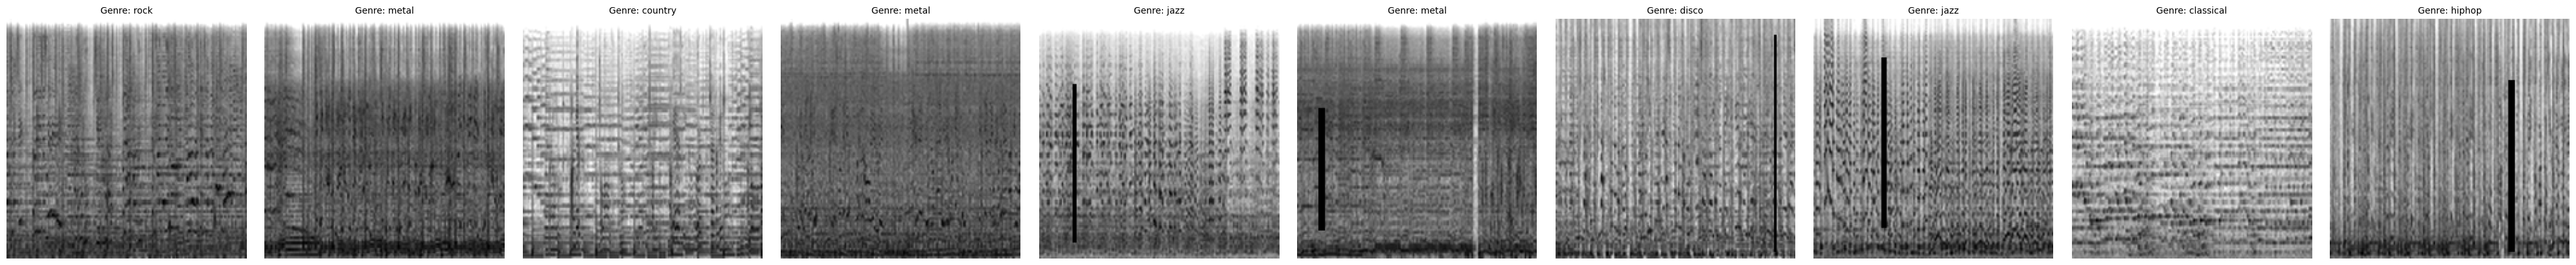

In [80]:
def show_images(loader, mean=0, std=1, num_images=12, figsize=(12, 9), denormalize=True):
    """
    Display a grid of images from a dataloader.

    Args:
        loader (DataLoader): DataLoader to get images from
        mean (float): Mean used for normalization, needed for denormalization
        std (float): Standard deviation used for normalization, needed for denormalization
        num_images (int): Number of images to display
        figsize (tuple): Figure size for the plot
        denormalize (bool): Whether to denormalize images before displaying
    """
    # Get a batch of images
    images, labels = next(iter(loader))

    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    axes = axes.ravel()  # Flatten the grid to make indexing easier

    # Calculate how many images to actually display
    num_to_display = min(num_images, len(images), len(axes))

    # Get class names from the dataset
    class_names = loader.dataset.dataset.classes

    # Plot images
    for idx in range(num_to_display):
        # Get the image and label
        img = images[idx]
        label_idx = labels[idx].item()
        class_name = class_names[label_idx]

        # Convert tensor to numpy for visualization
        img_np = img.cpu().numpy()

        # Handle grayscale images
        if img_np.shape[0] == 1:
            img_np = img_np.squeeze(0)  # Remove the channel dimension

            # Denormalize if requested
            if denormalize:
                img_np = img_np * std + mean

            axes[idx].imshow(img_np, cmap='gray')
        else:
            # Handle RGB images
            if denormalize:
                img_np = img_np * std + mean

            img_np = np.transpose(img_np, (1, 2, 0))  # Change from [C,H,W] to [H,W,C]
            axes[idx].imshow(img_np)

        # Add title and turn off axis
        axes[idx].set_title(f'Genre: {class_name}', fontsize=10)
        axes[idx].axis('off')

    # Hide any unused subplots
    for idx in range(num_to_display, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return class_names

# Show sample images from the training set
num_images = 10
class_names = show_images(
    train_loader,
    mean=mean,
    std=std,
    num_images=num_images,
    figsize=(4*num_images, 4),
    denormalize=True
)

## Training and Evaluation Functions for Net 1-4

This section provides reusable functions for training and evaluating models.

In [81]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The neural network model
        dataloader (DataLoader): DataLoader for the training set
        criterion (nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimizer
        device (torch.device): Device to run the model on

    Returns:
        tuple: (epoch_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return epoch_loss, accuracy

In [82]:
def validate(model, dataloader, criterion, device):
    """
    Validate the model on a validation set.

    Args:
        model (nn.Module): The neural network model
        dataloader (DataLoader): DataLoader for the validation set
        criterion (nn.Module): Loss function
        device (torch.device): Device to run the model on

    Returns:
        tuple: (val_loss, accuracy)
    """
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(dataloader)
    accuracy = val_correct / val_total

    return val_loss, accuracy

In [ ]:
def test_model(model, dataloader, device, class_names=None, plot_cm=True, experiment=None, metric_name=None):
    """
    Test the model on a test set, calculate detailed metrics (Accuracy, Precision, Recall, F1),
    and generate a confusion matrix. This function is designed to work generically
    for various model types (CNN, FCNN, LSTM).

    Args:
        model (nn.Module): The trained neural network model.
        dataloader (DataLoader): DataLoader for the test set.
        device (torch.device): Device to run the model on.
        class_names (list, optional): List of class names for labeling the confusion matrix and report.
        plot_cm (bool, optional): Whether to plot the confusion matrix. Defaults to True.
        experiment (comet_ml.Experiment, optional): Comet.ml experiment object for logging. Defaults to None.
        metric_name (str, optional): Base name to use for logging metrics (e.g., 'net1_test', 'lstm_test').

    Returns:
        tuple: (test_accuracy, micro_f1, macro_f1, confusion_matrix, classification_report_str)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and true labels for metric calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Calculate Metrics ---
    test_accuracy = accuracy_score(y_true, y_pred)
    # Use zero_division=0 to handle cases where a class has no predictions/true labels in the test set slice
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_m = confusion_matrix(y_true, y_pred)
    # Generate classification report (includes precision, recall, f1 per class, and averages)
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4, # Number of digits for precision
        zero_division=0 # How to handle division by zero
    )

    # --- Printing Results ---
    print("-" * 80)
    print(f"Test Results ({metric_name if metric_name else 'Model'}):")
    print("-" * 80)
    print(f'Overall Test Accuracy : {test_accuracy * 100:.2f}%')
    print(f'Micro F1 Score        : {micro_f1:.4f}')
    print(f'Macro F1 Score        : {macro_f1:.4f}')
    print("\nClassification Report:")
    print(report)
    print("-" * 80)

    # --- Logging to Experiment ---
    if experiment is not None:
        log_prefix = f"{metric_name}_" if metric_name else "test_"
        # Log primary metrics
        experiment.log_metric(f"{log_prefix}accuracy", test_accuracy)
        experiment.log_metric(f"{log_prefix}micro_f1", micro_f1)
        experiment.log_metric(f"{log_prefix}macro_f1", macro_f1)
        experiment.log_text(report, metadata={'name': f'{log_prefix}classification_report'})
        experiment.log_confusion_matrix(matrix=conf_m, labels=class_names, title=f'{log_prefix}Confusion Matrix')

    # --- Plotting Confusion Matrix ---
    if plot_cm:
        plt.figure(figsize=(12, 8))
        try:
            # Ensure class_names length matches the number of classes in conf_m if provided
            effective_labels = class_names if class_names is not None and len(class_names) == conf_m.shape[0] else None
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=effective_labels)
            disp.plot(cmap='Blues', xticks_rotation=45)
            title = f'Confusion Matrix ({metric_name})' if metric_name else 'Confusion Matrix on Test Set'
            if effective_labels is None and class_names is not None:
                 title += " (Labels Mismatch)"
                 print(f"Warning: Provided class_names length ({len(class_names)}) doesn't match confusion matrix dimension ({conf_m.shape[0]}). Plotting without labels.")
            plt.title(title)

        except Exception as e: # Catch potential errors during plotting
             print(f"Error plotting confusion matrix: {e}")
             # Fallback plotting without labels
             disp = ConfusionMatrixDisplay(confusion_matrix=conf_m)
             disp.plot(cmap='Blues', xticks_rotation=45)
             plt.title(f'Confusion Matrix ({metric_name}) - Plotting Error' if metric_name else 'Confusion Matrix on Test Set - Plotting Error')

        plt.tight_layout()
        plt.show()

    return test_accuracy, micro_f1, macro_f1, conf_m, report



In [84]:
def train_model(model, train_loader, val_loader, test_loader, num_epochs, lr, device, experiment=None,
                 optimizer_type='adam', model_name='model', class_names=None):
    """
    Train and evaluate a model.

    Args:
        model (nn.Module): The neural network model
        train_loader (DataLoader): DataLoader for the training set
        val_loader (DataLoader): DataLoader for the validation set
        test_loader (DataLoader): DataLoader for the test set
        num_epochs (int): Number of epochs to train for
        lr (float): Learning rate
        device (torch.device): Device to run the model on
        experiment (comet_ml.Experiment): Comet.ml experiment object
        optimizer_type (str): Type of optimizer to use ('adam' or 'rmsprop')
        model_name (str): Name of the model for logging
        class_names (list): List of class names

    Returns:
        tuple: (model, train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, confusion_matrix)
    """
    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Log parameters to experiment if provided
    if experiment is not None:
        experiment.log_parameters({
            'model': model_name,
            'optimizer': optimizer_type,
            'lr': lr,
            'batch_size': train_loader.batch_size if hasattr(train_loader, 'batch_size') else 'unknown',
            'epochs': num_epochs
        })

    # Initialize lists to track metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Train for specified number of epochs
    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Log metrics to experiment if provided
        if experiment is not None:
            experiment.log_metric(f"train_loss_{model_name}", train_loss, epoch=epoch)
            experiment.log_metric(f"val_loss_{model_name}", val_loss, epoch=epoch)
            experiment.log_metric(f"train_accuracy_{model_name}", train_accuracy, epoch=epoch)
            experiment.log_metric(f"val_accuracy_{model_name}", val_accuracy, epoch=epoch)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] \n"
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.4f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.4f}%")
        print("-" * 80)

    # Print best metrics
    best_train_accuracy = max(train_accuracies)
    lowest_train_loss = min(train_losses)
    best_val_accuracy = max(val_accuracies)
    lowest_val_loss = min(val_losses)

    print(f"\nBest Achieved Metrics with {num_epochs} epochs")
    print("=" * 40)
    print(f"Highest Training Accuracy : {best_train_accuracy * 100:.4f}%")
    print(f"Lowest Training Loss      : {lowest_train_loss:.4f}")
    print("-" * 40)
    print(f"Highest Validation Accuracy : {best_val_accuracy * 100:.4f}%")
    print(f"Lowest Validation Loss      : {lowest_val_loss:.4f}")
    print("=" * 40)

    # Evaluate on test set
    test_metric_name = f"{model_name}_test" # Construct a meaningful name
    test_accuracy, micro_f1, macro_f1, conf_m, report_str = test_model(
        model=model,
        dataloader=test_loader,
        device=device,
        class_names=class_names,
        plot_cm=True,
        experiment=experiment,
        metric_name=test_metric_name # Pass the specific name for logging
    )

    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'confusion_matrix': conf_m
    }

    return results_dict

In [88]:

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, title_prefix=""):
    """
    Plot the training and validation losses and accuracies.

    Args:
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_accuracies (list): Training accuracies
        val_accuracies (list): Validation accuracies
        title_prefix (str): Prefix for the plot titles
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title_prefix} Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot([acc * 100 for acc in train_accuracies], label='Training Accuracy')
    ax2.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title_prefix} Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


## Model Architecture 1: Fully Connected Neural Network <a id="model-1-fully-connected"></a>

This section implements a fully connected neural network with two hidden layers for music genre classification.

In [89]:
class Net1(nn.Module):
    """
    Fully Connected Neural Network with two hidden layers for image classification.

    Architecture:
    - Input: Flattened image (180x180 = 32400 features)
    - Hidden Layer 1: 512 neurons with ReLU
    - Hidden Layer 2: 256 neurons with ReLU
    - Output Layer: 10 neurons (one for each genre)
    """
    def __init__(self, input_size=180*180, hidden_size1=512, hidden_size2=256, num_classes=10):
        super(Net1, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input
        x = x.flatten(start_dim=1)  # Flatten all dimensions after the batch dimension
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

# Initialize the model
net1_model = Net1(input_size=IMAGE_SIZE*IMAGE_SIZE, num_classes=NUM_CLASSES)
net1_model = net1_model.to(device)

### Training Net1 with 50 epochs

Epoch [1/50] 
Train Loss: 2.1478 | Train Accuracy: 19.5994% | Val Loss: 1.9590 | Val Accuracy: 21.1055%
--------------------------------------------------------------------------------
Epoch [2/50] 
Train Loss: 1.9240 | Train Accuracy: 27.4678% | Val Loss: 1.8535 | Val Accuracy: 24.6231%
--------------------------------------------------------------------------------
Epoch [3/50] 
Train Loss: 1.8001 | Train Accuracy: 37.6252% | Val Loss: 1.7660 | Val Accuracy: 36.6834%
--------------------------------------------------------------------------------
Epoch [4/50] 
Train Loss: 1.6922 | Train Accuracy: 46.0658% | Val Loss: 1.6707 | Val Accuracy: 40.7035%
--------------------------------------------------------------------------------
Epoch [5/50] 
Train Loss: 1.5903 | Train Accuracy: 48.9270% | Val Loss: 1.6614 | Val Accuracy: 44.7236%
--------------------------------------------------------------------------------
Epoch [6/50] 
Train Loss: 1.4652 | Train Accuracy: 56.9385% | Val Loss: 1.5

<Figure size 1200x800 with 0 Axes>

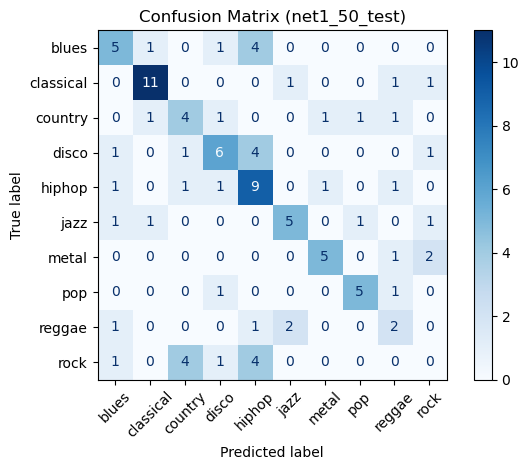

In [90]:
# Train the fully connected network for 50 epochs
net1_epochs_50 = 50
net1_lr = 0.00001

net1_50_results = train_model(
    model=net1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net1_epochs_50,
    lr=net1_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net1_50',
    class_names=class_names
)

### Visualize Net1 Training Results (50 epochs)

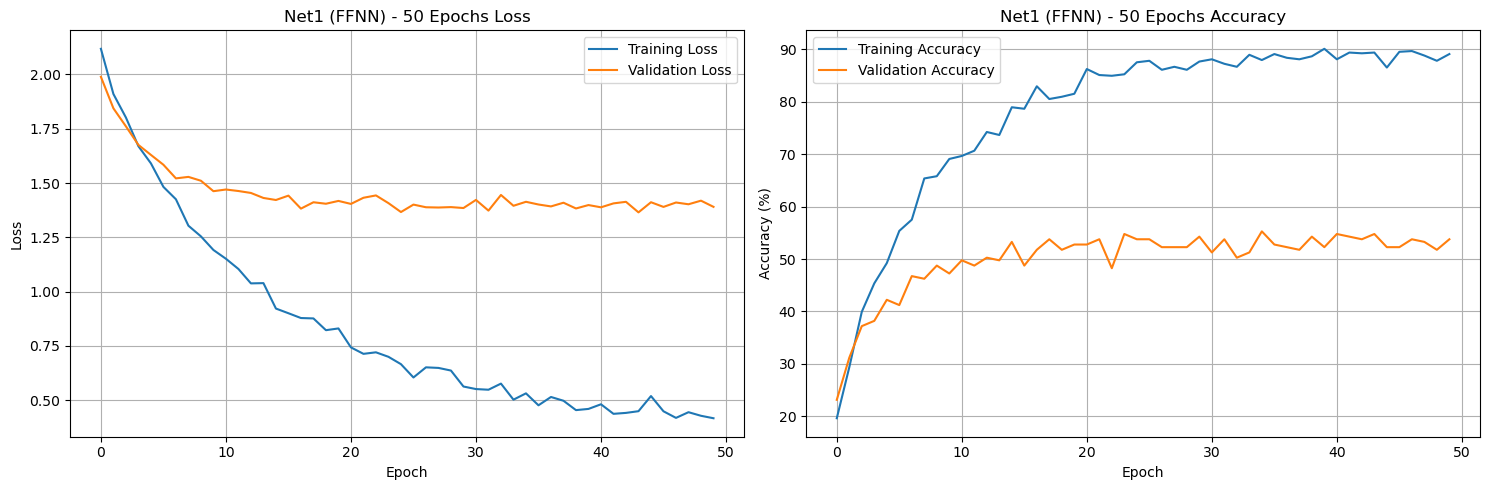

In [ ]:
plot_training_history(
    net1_50_results['train_losses'],
    net1_50_results['val_losses'],
    net1_50_results['train_accuracies'],
    net1_50_results['val_accuracies'],
    title_prefix="Net1 (FFNN) - 50 Epochs"
)

### Training Net1 with 100 epochs

Epoch [1/100] 
Train Loss: 2.1376 | Train Accuracy: 20.6009% | Val Loss: 1.9698 | Val Accuracy: 21.1055%
--------------------------------------------------------------------------------
Epoch [2/100] 
Train Loss: 1.9160 | Train Accuracy: 29.1845% | Val Loss: 1.8547 | Val Accuracy: 25.6281%
--------------------------------------------------------------------------------
Epoch [3/100] 
Train Loss: 1.7754 | Train Accuracy: 38.1974% | Val Loss: 1.7246 | Val Accuracy: 40.2010%
--------------------------------------------------------------------------------
Epoch [4/100] 
Train Loss: 1.6658 | Train Accuracy: 44.3491% | Val Loss: 1.6801 | Val Accuracy: 41.2060%
--------------------------------------------------------------------------------
Epoch [5/100] 
Train Loss: 1.5503 | Train Accuracy: 52.5036% | Val Loss: 1.6240 | Val Accuracy: 42.2111%
--------------------------------------------------------------------------------
Epoch [6/100] 
Train Loss: 1.4642 | Train Accuracy: 55.5079% | Val Los

<Figure size 1200x800 with 0 Axes>

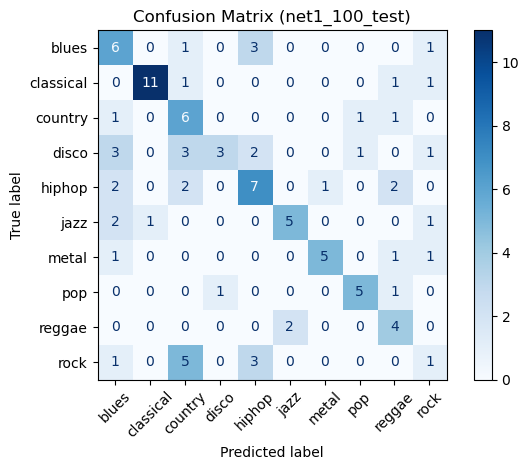

In [ ]:
# Reinitialize the model for a fair comparison
net1_model_100 = Net1(input_size=IMAGE_SIZE*IMAGE_SIZE, num_classes=NUM_CLASSES).to(device)

# Train for 100 epochs
net1_epochs_100 = 100
net1_lr_100 = 0.00001
net1_results_100 = train_model(
    model=net1_model_100,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net1_epochs_100,
    lr=net1_lr_100,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net1_100',
    class_names=class_names
)

### Visualize Net1 Training Results (100 epochs)

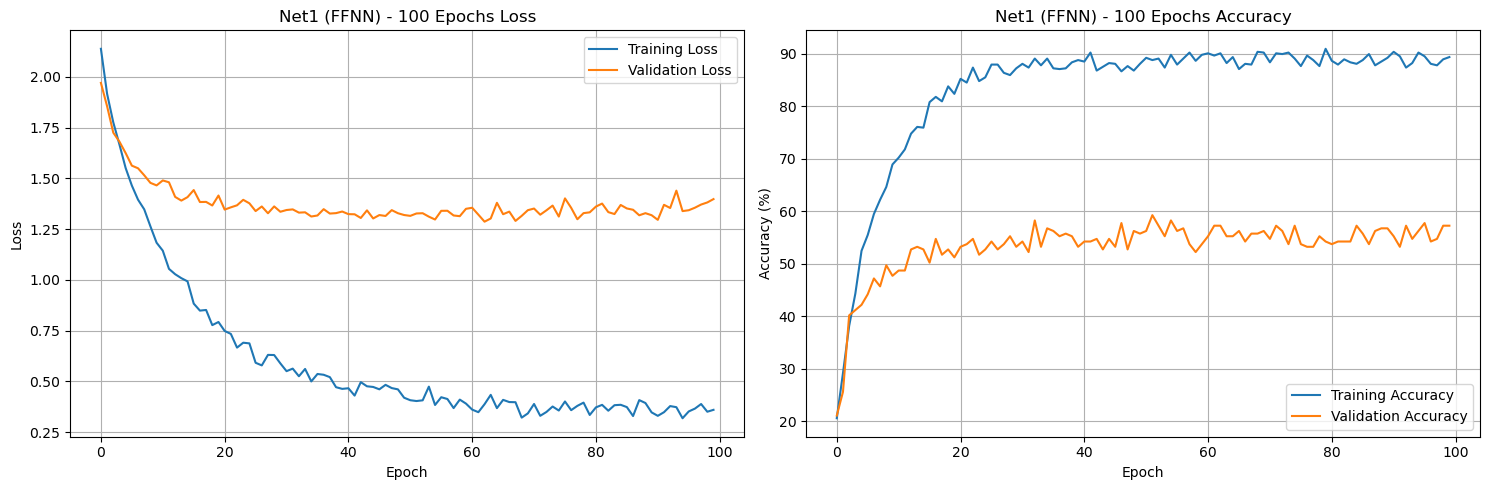

In [91]:
plot_training_history(
    net1_results_100['train_losses'],
    net1_results_100['val_losses'],
    net1_results_100['train_accuracies'],
    net1_results_100['val_accuracies'],
    title_prefix="Net1 (FFNN) - 100 Epochs"
)

## Model Architecture 2: Convolutional Neural Network <a id="model-2-cnn"></a>

This section implements a CNN model for music genre classification.

In [92]:
class Net2(nn.Module):
    """
    Convolutional Neural Network for image classification.

    Architecture:
    - Conv Layers: 4 (32 → 64 → 128 → 256 filters)
    - Max Pooling: After each pair of conv layers
    - Fully Connected: 256*45*45 → 256 → 10 classes
    """
    def __init__(self, in_channels=1, num_classes=10):
        super(Net2, self).__init__()
        # First 2 conv layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


        # Final 2 conv layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*45*45, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
net2_model = Net2(in_channels=1, num_classes=NUM_CLASSES).to(device)

### Training Net2 with 50 epochs

Epoch [1/50] 
Train Loss: 2.2439 | Train Accuracy: 15.8798% | Val Loss: 2.1485 | Val Accuracy: 24.6231%
--------------------------------------------------------------------------------
Epoch [2/50] 
Train Loss: 2.0740 | Train Accuracy: 28.8984% | Val Loss: 1.9876 | Val Accuracy: 30.6533%
--------------------------------------------------------------------------------
Epoch [3/50] 
Train Loss: 1.9155 | Train Accuracy: 32.6180% | Val Loss: 1.7959 | Val Accuracy: 39.6985%
--------------------------------------------------------------------------------
Epoch [4/50] 
Train Loss: 1.7561 | Train Accuracy: 40.2003% | Val Loss: 1.6083 | Val Accuracy: 47.2362%
--------------------------------------------------------------------------------
Epoch [5/50] 
Train Loss: 1.6375 | Train Accuracy: 42.3462% | Val Loss: 1.5884 | Val Accuracy: 45.2261%
--------------------------------------------------------------------------------
Epoch [6/50] 
Train Loss: 1.5946 | Train Accuracy: 43.4907% | Val Loss: 1.4

<Figure size 1200x800 with 0 Axes>

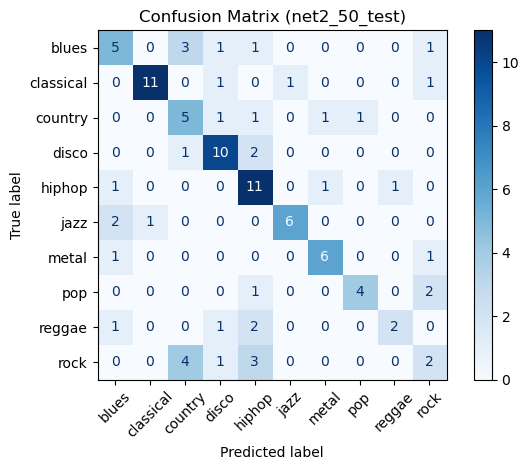

In [93]:
# Train the CNN model for 50 epochs
net2_epochs_50 = 50
net2_lr = 0.00001

net2_results_50 = train_model(
    model=net2_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net2_epochs_50,
    lr=net2_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net2_50',
    class_names=class_names
)

### Visualize Net2 Training Results (50 epochs)

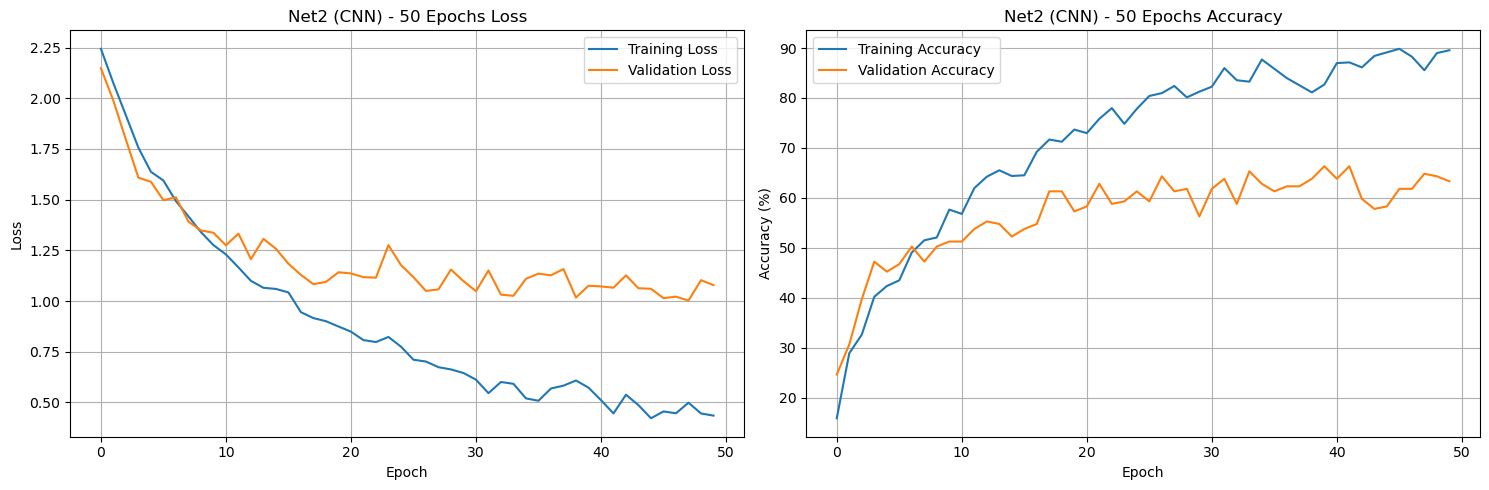

In [94]:
plot_training_history(
    net2_results_50['train_losses'],
    net2_results_50['val_losses'],
    net2_results_50['train_accuracies'],
    net2_results_50['val_accuracies'],
    title_prefix="Net2 (CNN) - 50 Epochs"
)

### Training Net2 with 100 epochs

Epoch [1/100] 
Train Loss: 2.2520 | Train Accuracy: 15.7368% | Val Loss: 2.1569 | Val Accuracy: 23.1156%
--------------------------------------------------------------------------------
Epoch [2/100] 
Train Loss: 2.0949 | Train Accuracy: 26.3233% | Val Loss: 1.9686 | Val Accuracy: 32.1608%
--------------------------------------------------------------------------------
Epoch [3/100] 
Train Loss: 1.9489 | Train Accuracy: 35.4793% | Val Loss: 1.8105 | Val Accuracy: 35.6784%
--------------------------------------------------------------------------------
Epoch [4/100] 
Train Loss: 1.8196 | Train Accuracy: 39.1989% | Val Loss: 1.7299 | Val Accuracy: 38.1910%
--------------------------------------------------------------------------------
Epoch [5/100] 
Train Loss: 1.7299 | Train Accuracy: 38.6266% | Val Loss: 1.6439 | Val Accuracy: 39.6985%
--------------------------------------------------------------------------------
Epoch [6/100] 
Train Loss: 1.6304 | Train Accuracy: 43.4907% | Val Los

<Figure size 1200x800 with 0 Axes>

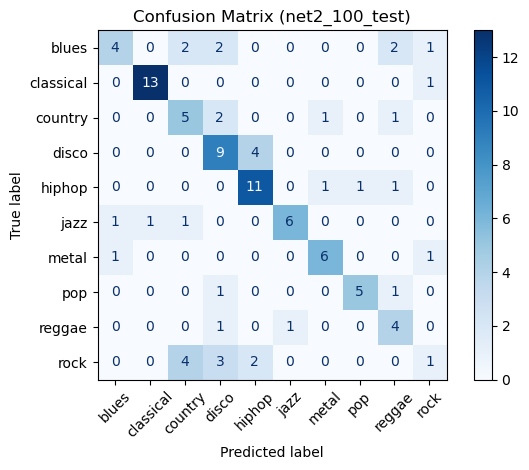

In [95]:
# Reinitialize the model for a fair comparison
net2_model_100 = Net2(in_channels=1, num_classes=NUM_CLASSES).to(device)

# Train for 100 epochs
net2_epochs_100 = 100

net2_results_100 = train_model(
    model=net2_model_100,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net2_epochs_100,
    lr=net2_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net2_100',
    class_names=class_names
)

### Visualize Net2 Training Results (100 epochs)

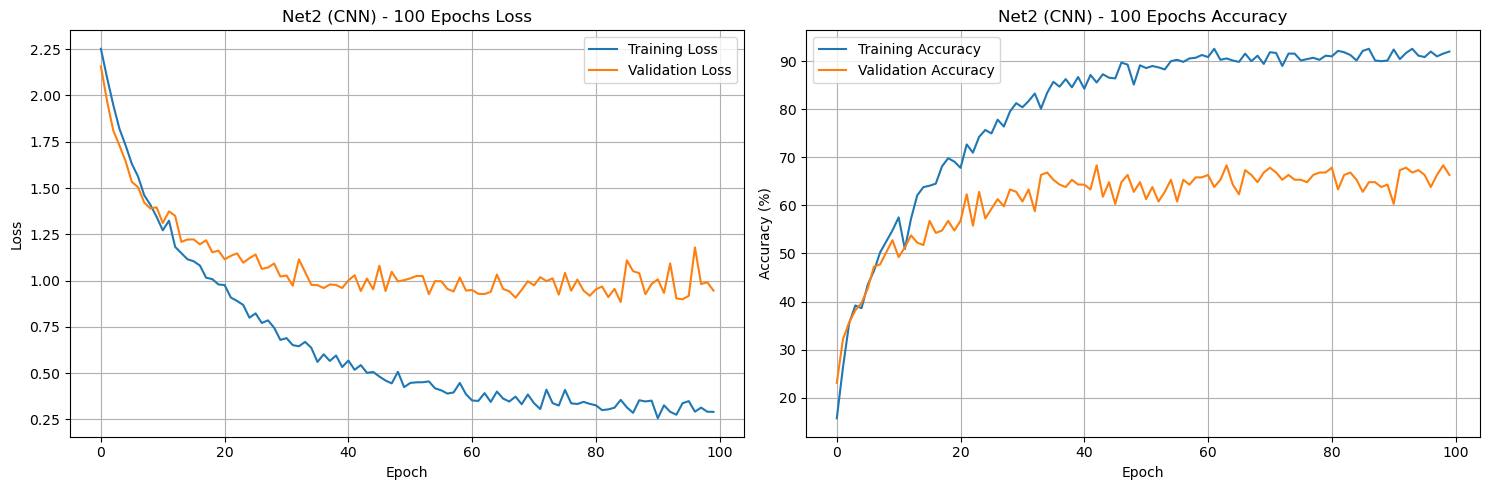

In [96]:
plot_training_history(
    net2_results_100['train_losses'],
    net2_results_100['val_losses'],
    net2_results_100['train_accuracies'],
    net2_results_100['val_accuracies'],
    title_prefix="Net2 (CNN) - 100 Epochs"
)

## Model Architecture 3: CNN with Batch Normalization <a id="model-3-cnn-bn"></a>

This section implements a CNN model with batch normalization for music genre classification.

In [97]:
class Net3(nn.Module):
    """
    Convolutional Neural Network with Batch Normalization for image classification.

    Architecture:
    - Conv Layers: 4 (32 → 64 → 128 → 256 filters) with Batch Normalization
    - Max Pooling: After each pair of conv layers
    - Fully Connected: 256*45*45 → 256 → 10 classes
    """
    def __init__(self, in_channels=1, num_classes=10):
        super(Net3, self).__init__()
        # First 2 conv layers with batch norm
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool= nn.MaxPool2d(2, 2)

        # Final 2 conv layers with batch norm
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*45*45, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.fc2(x)
        return x

# Initialize the model
net3_model = Net3(in_channels=1, num_classes=NUM_CLASSES).to(device)

### Training Net3 with 50 epochs

Epoch [1/50] 
Train Loss: 1.7284 | Train Accuracy: 43.0615% | Val Loss: 2.1315 | Val Accuracy: 23.1156%
--------------------------------------------------------------------------------
Epoch [2/50] 
Train Loss: 1.0118 | Train Accuracy: 77.5393% | Val Loss: 1.5303 | Val Accuracy: 43.7186%
--------------------------------------------------------------------------------
Epoch [3/50] 
Train Loss: 0.7842 | Train Accuracy: 81.9742% | Val Loss: 1.2655 | Val Accuracy: 66.3317%
--------------------------------------------------------------------------------
Epoch [4/50] 
Train Loss: 0.5816 | Train Accuracy: 88.1259% | Val Loss: 1.1877 | Val Accuracy: 68.3417%
--------------------------------------------------------------------------------
Epoch [5/50] 
Train Loss: 0.4752 | Train Accuracy: 91.1302% | Val Loss: 1.8768 | Val Accuracy: 34.6734%
--------------------------------------------------------------------------------
Epoch [6/50] 
Train Loss: 0.4571 | Train Accuracy: 89.4134% | Val Loss: 1.2

<Figure size 1200x800 with 0 Axes>

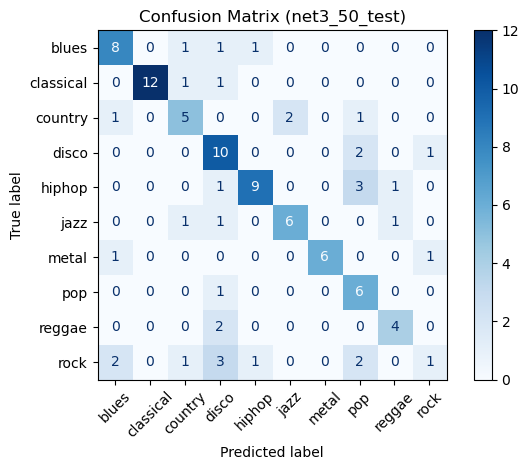

In [98]:
# Train the CNN model with Batch Normalization for 50 epochs
net3_epochs_50 = 50
net3_lr = 0.00001

net3_results_50 = train_model(
    model=net3_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net3_epochs_50,
    lr=net3_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net3_50',
    class_names=class_names
)

### Visualize Net3 Training Results (50 epochs)

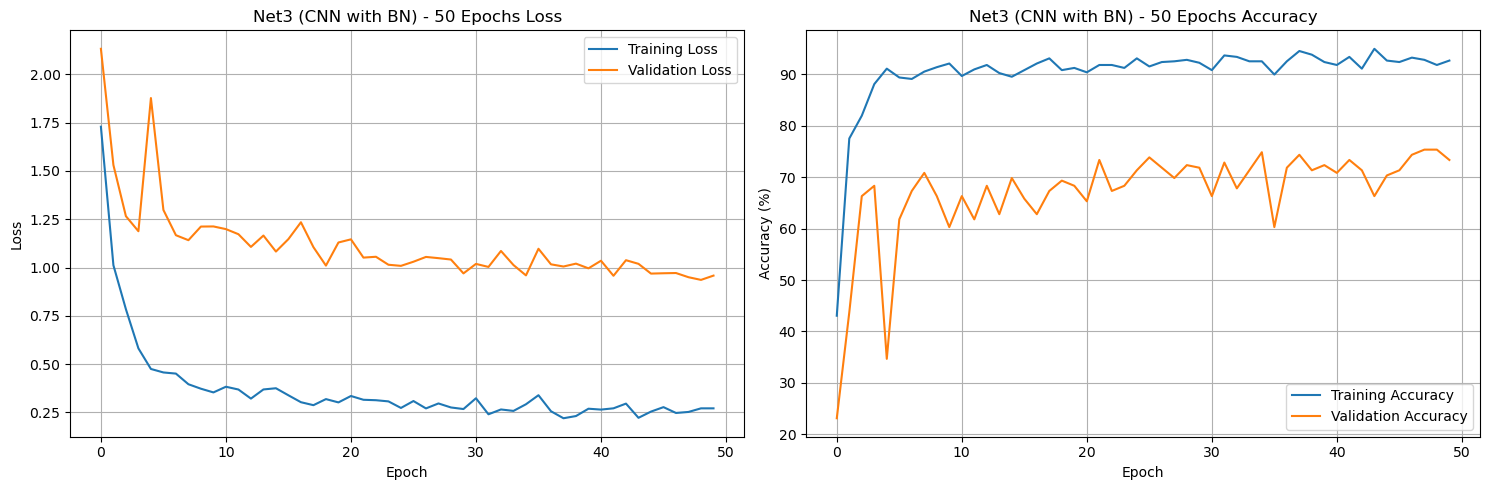

In [99]:
plot_training_history(
    net3_results_50['train_losses'],
    net3_results_50['val_losses'],
    net3_results_50['train_accuracies'],
    net3_results_50['val_accuracies'],
    title_prefix="Net3 (CNN with BN) - 50 Epochs"
)

### Training Net3 with 100 epochs

Epoch [1/100] 
Train Loss: 1.7053 | Train Accuracy: 42.6323% | Val Loss: 2.2466 | Val Accuracy: 25.1256%
--------------------------------------------------------------------------------
Epoch [2/100] 
Train Loss: 0.9973 | Train Accuracy: 75.6795% | Val Loss: 1.3949 | Val Accuracy: 55.7789%
--------------------------------------------------------------------------------
Epoch [3/100] 
Train Loss: 0.7159 | Train Accuracy: 87.8398% | Val Loss: 1.2581 | Val Accuracy: 58.2915%
--------------------------------------------------------------------------------
Epoch [4/100] 
Train Loss: 0.5600 | Train Accuracy: 88.8412% | Val Loss: 1.2686 | Val Accuracy: 62.8141%
--------------------------------------------------------------------------------
Epoch [5/100] 
Train Loss: 0.4693 | Train Accuracy: 90.4149% | Val Loss: 1.1705 | Val Accuracy: 65.8291%
--------------------------------------------------------------------------------
Epoch [6/100] 
Train Loss: 0.4719 | Train Accuracy: 88.5551% | Val Los

<Figure size 1200x800 with 0 Axes>

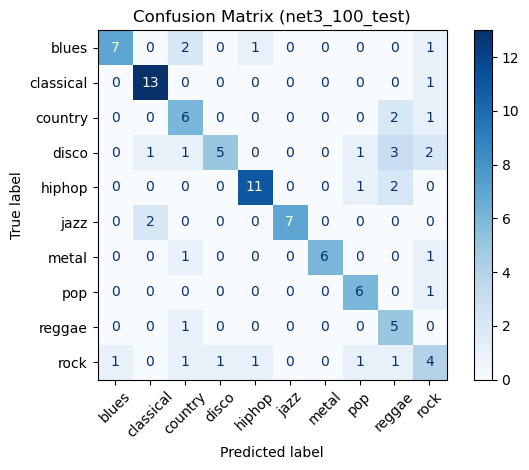

In [152]:
net3_model_100 = Net3(in_channels=1, num_classes=NUM_CLASSES).to(device)

# Train for 100 epochs
net3_epochs_100 = 100

net3_results_100 = train_model(
    model=net3_model_100,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net3_epochs_100,
    lr=net3_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net3_100',
    class_names=class_names
)

### Visualize Net3 Training Results (100 epochs)

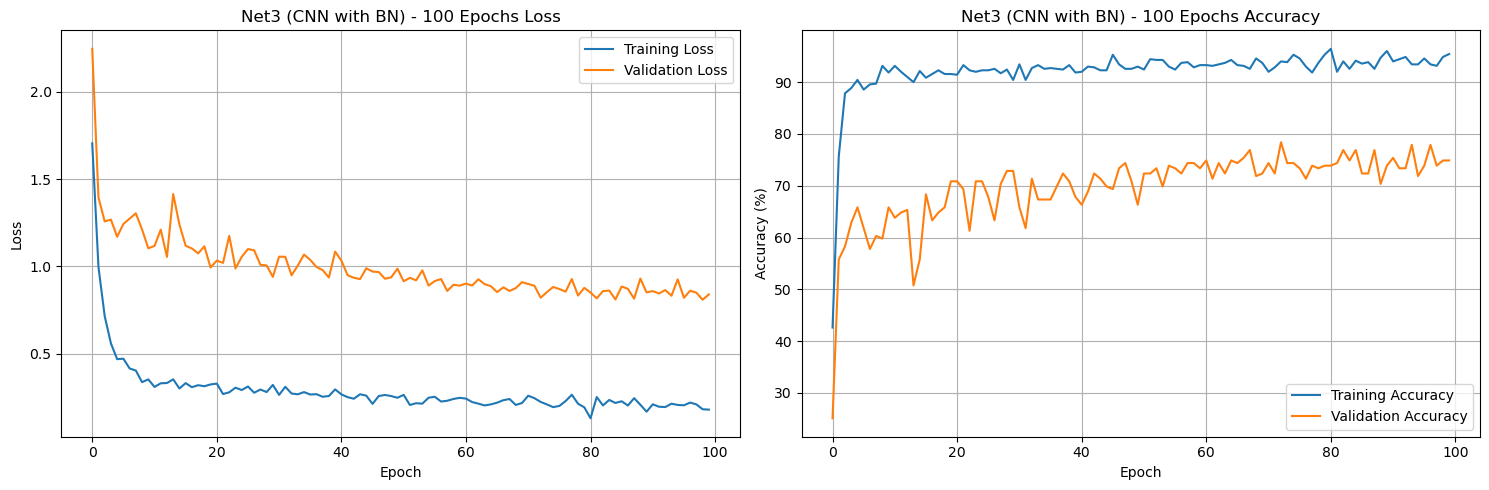

In [153]:
plot_training_history(
    net3_results_100['train_losses'],
    net3_results_100['val_losses'],
    net3_results_100['train_accuracies'],
    net3_results_100['val_accuracies'],
    title_prefix="Net3 (CNN with BN) - 100 Epochs"
)

## Model Architecture 4: CNN with Batch Normalization and RMSprop <a id="model-4-cnn-bn-rmsprop"></a>

This section implements a CNN model with batch normalization and RMSprop optimizer for music genre classification.

In [102]:
class Net4(nn.Module):
    """
    Convolutional Neural Network with Batch Normalization and RMSprop optimizer for image classification.

    Architecture:
    - Conv Layers: 4 (32 → 64 → 128 → 256 filters) with Batch Normalization
    - Max Pooling: After each pair of conv layers
    - Fully Connected: 256*45*45 → 256 → 10 classes
    """
    def __init__(self, in_channels=1, num_classes=10):
        super(Net4, self).__init__()
        # First 2 conv layers with batch norm
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        # Final 2 conv layers with batch norm
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        #self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*45*45, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.fc2(x)
        return x

# Initialise the model
net4_model = Net4(in_channels=1, num_classes=NUM_CLASSES).to(device)

### Training Net4 with 50 epochs

Epoch [1/50] 
Train Loss: 1.7291 | Train Accuracy: 40.9156% | Val Loss: 2.1975 | Val Accuracy: 31.6583%
--------------------------------------------------------------------------------
Epoch [2/50] 
Train Loss: 0.9203 | Train Accuracy: 78.3977% | Val Loss: 1.6536 | Val Accuracy: 42.7136%
--------------------------------------------------------------------------------
Epoch [3/50] 
Train Loss: 0.6530 | Train Accuracy: 86.5522% | Val Loss: 1.3517 | Val Accuracy: 54.7739%
--------------------------------------------------------------------------------
Epoch [4/50] 
Train Loss: 0.4974 | Train Accuracy: 88.6981% | Val Loss: 1.4658 | Val Accuracy: 48.7437%
--------------------------------------------------------------------------------
Epoch [5/50] 
Train Loss: 0.4111 | Train Accuracy: 90.9871% | Val Loss: 1.2912 | Val Accuracy: 61.8090%
--------------------------------------------------------------------------------
Epoch [6/50] 
Train Loss: 0.4198 | Train Accuracy: 90.2718% | Val Loss: 1.1

<Figure size 1200x800 with 0 Axes>

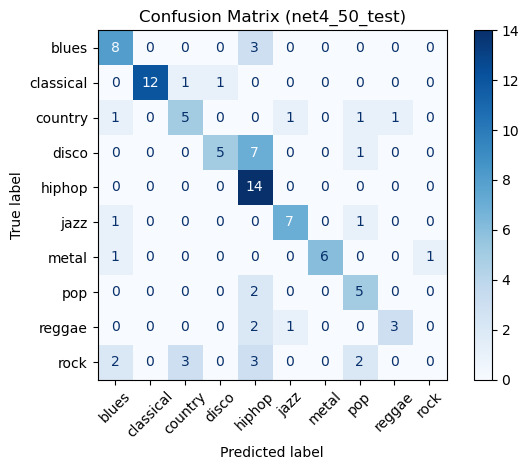

In [103]:
# Train the CNN model with Batch Normalisation and RMSprop for 50 epochs
net4_epochs_50 = 50
net4_lr = 0.00001

net4_results_50 = train_model(
    model=net4_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net4_epochs_50,
    lr=net4_lr,
    device=device,
    experiment=experiment,
    optimizer_type='rmsprop',  # Using RMSprop optimiser
    model_name='net4_50',
    class_names=class_names
)

### Visualize Net4 Training Results (50 epochs)

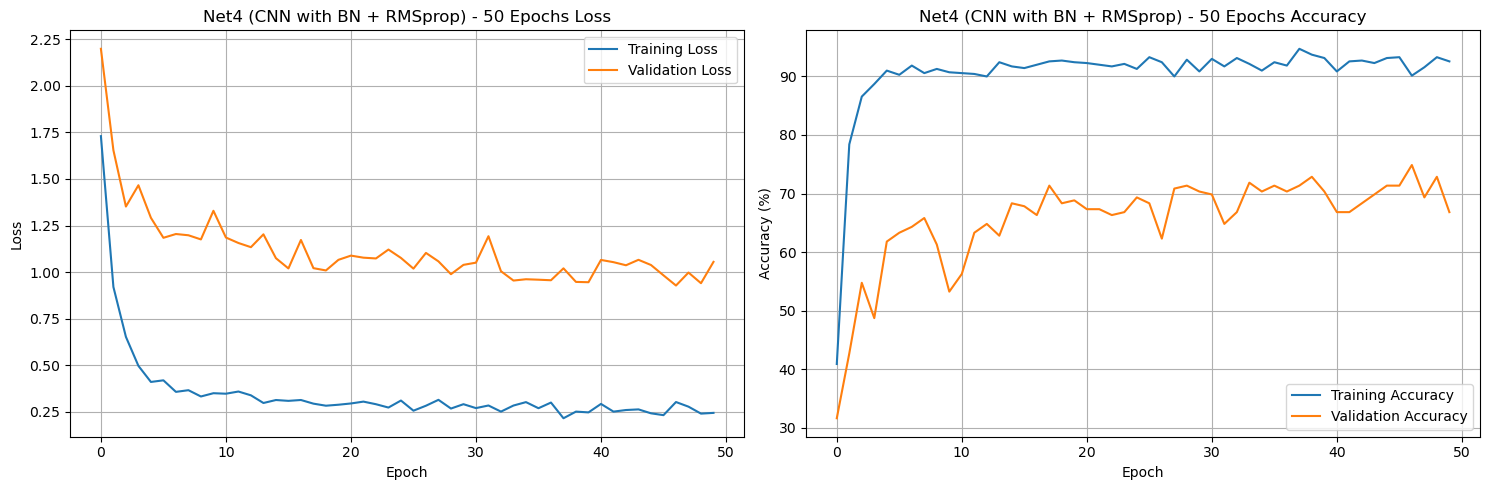

In [104]:
plot_training_history(
    net4_results_50['train_losses'],
    net4_results_50['val_losses'],
    net4_results_50['train_accuracies'],
    net4_results_50['val_accuracies'],
    title_prefix="Net4 (CNN with BN + RMSprop) - 50 Epochs"
)

### Training Net4 with 100 epochs

Epoch [1/100] 
Train Loss: 1.6904 | Train Accuracy: 43.4907% | Val Loss: 2.1412 | Val Accuracy: 26.1307%
--------------------------------------------------------------------------------
Epoch [2/100] 
Train Loss: 0.9040 | Train Accuracy: 79.6853% | Val Loss: 1.5062 | Val Accuracy: 55.2764%
--------------------------------------------------------------------------------
Epoch [3/100] 
Train Loss: 0.5766 | Train Accuracy: 89.4134% | Val Loss: 1.2679 | Val Accuracy: 58.2915%
--------------------------------------------------------------------------------
Epoch [4/100] 
Train Loss: 0.4839 | Train Accuracy: 89.8426% | Val Loss: 1.2408 | Val Accuracy: 60.8040%
--------------------------------------------------------------------------------
Epoch [5/100] 
Train Loss: 0.4119 | Train Accuracy: 91.2732% | Val Loss: 1.2167 | Val Accuracy: 60.3015%
--------------------------------------------------------------------------------
Epoch [6/100] 
Train Loss: 0.4506 | Train Accuracy: 88.6981% | Val Los

<Figure size 1200x800 with 0 Axes>

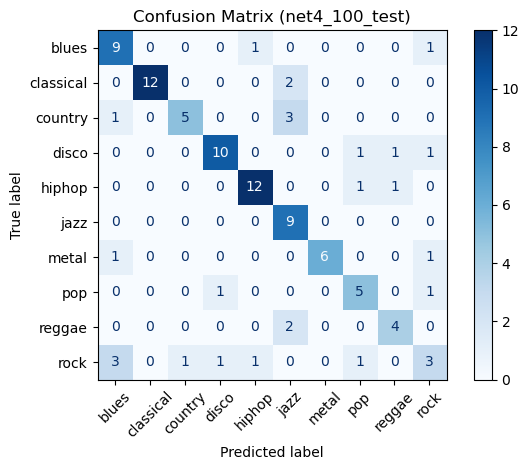

In [105]:
# Reinitialize the model for a fair comparison
net4_model_100 = Net4(in_channels=1, num_classes=NUM_CLASSES).to(device)

# Train for 100 epochs
net4_epochs_100 = 100

net4_results_100 = train_model(
    model=net4_model_100,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net4_epochs_100,
    lr=net4_lr,
    device=device,
    experiment=experiment,
    optimizer_type='rmsprop',  # Using RMSprop optimizer
    model_name='net4_100',
    class_names=class_names
)

### Visualize Net4 Training Results (100 epochs)

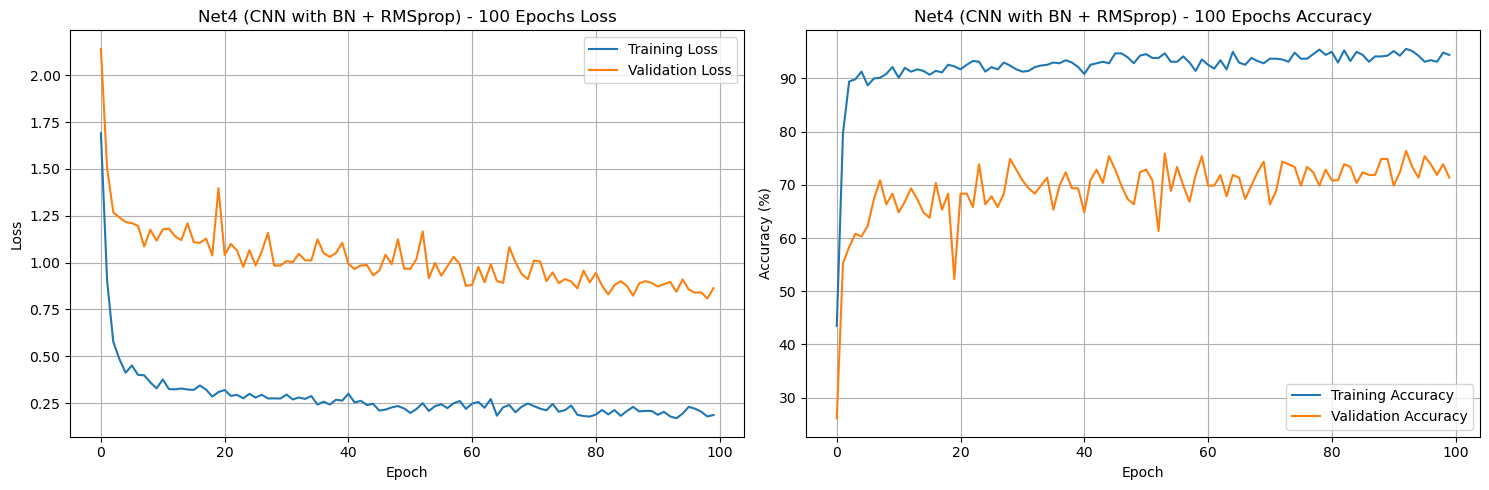

In [106]:
plot_training_history(
    net4_results_100['train_losses'],
    net4_results_100['val_losses'],
    net4_results_100['train_accuracies'],
    net4_results_100['val_accuracies'],
    title_prefix="Net4 (CNN with BN + RMSprop) - 100 Epochs"
)

## Model Architecture 5: LSTM <a id="model-5-lstm"></a>

This section implements an LSTM model for music genre classification using MFCCs as input features.

In [107]:
print(device)

mps


### Data Preparation

In [108]:
def load_audio_files(wav_path):
    """
    Load audio files from path and create labels based on folder structure.
    """
    print(f"Loading audio files from {wav_path}...")
    audio_files = []
    labels = []
    genres = os.listdir(wav_path)
    genres_to_id = {genre: i for i, genre in enumerate(genres)}

    for genre in genres:
        genre_path = os.path.join(wav_path, genre)
        files = glob.glob(os.path.join(genre_path, '*.wav'))
        audio_files.extend(files)
        labels.extend([genres_to_id[genre]] * len(files))
    print(f"Loaded {len(audio_files)} audio files from {len(genres)} genres.")
    return audio_files, labels, genres_to_id

wav_path = 'Data/genres_original'
audio_files, labels, genres_to_id = load_audio_files(wav_path)
print(f"Audio files: {audio_files[400:405]}")
print(f"Labels: {labels.count(0)}")
print(f"Genres to ID mapping: {genres_to_id}")
# Create a reverse mapping for future use
id_to_genre = {v: k for k, v in genres_to_id.items()}

Loading audio files from Data/genres_original...
Loaded 1000 audio files from 10 genres.
Audio files: ['Data/genres_original/reggae/reggae.00080.wav', 'Data/genres_original/reggae/reggae.00094.wav', 'Data/genres_original/reggae/reggae.00043.wav', 'Data/genres_original/reggae/reggae.00057.wav', 'Data/genres_original/reggae/reggae.00056.wav']
Labels: 100
Genres to ID mapping: {'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


In [109]:
# Manual dataset split into 70% training, 20% validation and 10% test sets
import random

# Set seed for reproducibility
random.seed(42)

# Calculate the total number of samples and split sizes
n_total = len(audio_files)
n_train = int(0.7 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

print(f"Dataset split - Total: {n_total}, Training: {n_train}, Validation: {n_val}, Test: {n_test}")

# Create indices for the entire dataset and shuffle them
indices = list(range(n_total))
random.shuffle(indices)

# Create stratified splits by genre
# First, organize file indices by genre
indices_by_genre = {}
for i, label in enumerate(labels):
    if label not in indices_by_genre:
        indices_by_genre[label] = []
    indices_by_genre[label].append(i)

# Initialize empty lists for each split
train_indices = []
val_indices = []
test_indices = []

# For each genre, split proportionally
for genre, genre_indices in indices_by_genre.items():
    # Shuffle the indices for this genre
    random.shuffle(genre_indices)
    
    # Calculate split sizes for this genre
    genre_count = len(genre_indices)
    genre_train = int(0.7 * genre_count)
    genre_val = int(0.2 * genre_count)
    
    # Split the indices
    train_indices.extend(genre_indices[:genre_train])
    val_indices.extend(genre_indices[genre_train:genre_train+genre_val])
    test_indices.extend(genre_indices[genre_train+genre_val:])

# Create the actual splits
X_train = [audio_files[i] for i in train_indices]
y_train = [labels[i] for i in train_indices]

X_val = [audio_files[i] for i in val_indices]
y_val = [labels[i] for i in val_indices]

X_test = [audio_files[i] for i in test_indices]
y_test = [labels[i] for i in test_indices]

# Verify the split sizes
print(f"Training set: {len(X_train)} files")
print(f"Validation set: {len(X_val)} files")
print(f"Test set: {len(X_test)} files")

# Check genre distribution to ensure stratification worked
for genre, idx in genres_to_id.items():
    train_count = y_train.count(idx)
    val_count = y_val.count(idx)
    test_count = y_test.count(idx)
    print(f"{genre}: {train_count} train, {val_count} val, {test_count} test")

Dataset split - Total: 1000, Training: 700, Validation: 200, Test: 100
Training set: 700 files
Validation set: 200 files
Test set: 100 files
pop: 70 train, 20 val, 10 test
metal: 70 train, 20 val, 10 test
disco: 70 train, 20 val, 10 test
blues: 70 train, 20 val, 10 test
reggae: 70 train, 20 val, 10 test
classical: 70 train, 20 val, 10 test
rock: 70 train, 20 val, 10 test
hiphop: 70 train, 20 val, 10 test
country: 70 train, 20 val, 10 test
jazz: 70 train, 20 val, 10 test


In [110]:
def segment_and_extract_features(audio_files_dict, segment_duration=3, sr=22050, n_mfcc=13):
    """
    Segment audio files and extract MFCC features while maintaining train/val/test splits.
    
    Args:
        audio_files_dict (dict): Dictionary with 'train', 'val', 'test' keys containing 
                                file paths and labels
        segment_duration (int): Duration of each segment in seconds
        sr (int): Sample rate for audio processing
        n_mfcc (int): Number of MFCC coefficients to extract
        
    Returns:
        dict: Dictionary with processed features and labels for each split
    """
    result = {}
    
    for split in ['train', 'val', 'test']:
        print(f"\nProcessing {split} split...")
        features = []
        labels = []
        files = audio_files_dict[split]['files']
        file_labels = audio_files_dict[split]['labels']
        
        # Process each file in this split
        for i, file_path in enumerate(tqdm(files, desc=f"Processing {split} files")):
            try:
                # Load audio
                y, sr = librosa.load(file_path, sr=sr)
                
                # Calculate segment length in samples
                segment_length = segment_duration * sr
                
                # Split audio into segments
                segments = []
                for start in range(0, len(y) - segment_length + 1, segment_length//2):  # 50% overlap
                    segment = y[start:start + segment_length]
                    if len(segment) == segment_length:  # Ensure we have a complete segment
                        segments.append(segment)
                
                # If no complete segments, pad the audio
                if len(segments) == 0 and len(y) > 0:
                    # Pad with zeros to reach segment_length
                    segment = np.pad(y, (0, segment_length - len(y)), 'constant')
                    segments.append(segment)
                
                # Extract features from each segment
                for segment in segments:
                    # Extract MFCCs
                    mfccs = librosa.feature.mfcc(
                        y=segment, 
                        sr=sr, 
                        n_mfcc=n_mfcc
                    )
                    # Transpose to get time as first dimension
                    mfccs = mfccs.T
                    
                    # Add to our collections
                    features.append(mfccs)
                    labels.append(file_labels[i])
                    
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        # Convert lists to numpy arrays
        if features:
            X = np.array(features)
            y = np.array(labels)
            
            # Store results
            result[split] = {
                'features': X,
                'labels': y
            }
            
            print(f"{split} set: {len(X)} segments, Shape: {X.shape}")
        else:
            print(f"Warning: No features extracted for {split} set")
    
    return result

# Organize your data into the expected format
audio_files_dict = {
    'train': {'files': X_train, 'labels': y_train},
    'val': {'files': X_val, 'labels': y_val},
    'test': {'files': X_test, 'labels': y_test}
}

# Process all splits
processed_data = segment_and_extract_features(
    audio_files_dict,
    segment_duration=3,
    sr=22050,
    n_mfcc=13
)

# Access the processed data
X_train_lstm = processed_data['train']['features']
y_train_lstm = processed_data['train']['labels']
X_val_lstm = processed_data['val']['features'] 
y_val_lstm = processed_data['val']['labels']
X_test_lstm = processed_data['test']['features']
y_test_lstm = processed_data['test']['labels']


Processing train split...


Processing train files: 100%|██████████| 700/700 [00:53<00:00, 13.21it/s]


train set: 13295 segments, Shape: (13295, 130, 13)

Processing val split...


Processing val files:  94%|█████████▍| 189/200 [00:14<00:00, 15.14it/s]/var/folders/pt/69g6_jnn3jn_02xm4dfl99_80000gn/T/ipykernel_5538/994467795.py:28: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/opt/homebrew/Caskroom/miniconda/base/envs/dlt_labs/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing val files:  96%|█████████▋| 193/200 [00:16<00:01,  3.79it/s]

Error processing Data/genres_original/jazz/jazz.00054.wav: 


Processing val files: 100%|██████████| 200/200 [00:16<00:00, 11.96it/s]


val set: 3779 segments, Shape: (3779, 130, 13)

Processing test split...


Processing test files: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


test set: 1898 segments, Shape: (1898, 130, 13)


In [111]:
def visualize_mfcc(mfcc_features, title="MFCC Features", figsize=(12, 6)):
    """
    Visualize MFCC features
    
    Args:
        mfcc_features: MFCC features array of shape [time, n_mfcc]
        title: Plot title
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Display MFCC
    librosa.display.specshow(
        mfcc_features.T,          # Transpose to get [n_mfcc, time]
        x_axis='time',
        sr=22050,
        hop_length=512,
        cmap='viridis'
    )
    
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

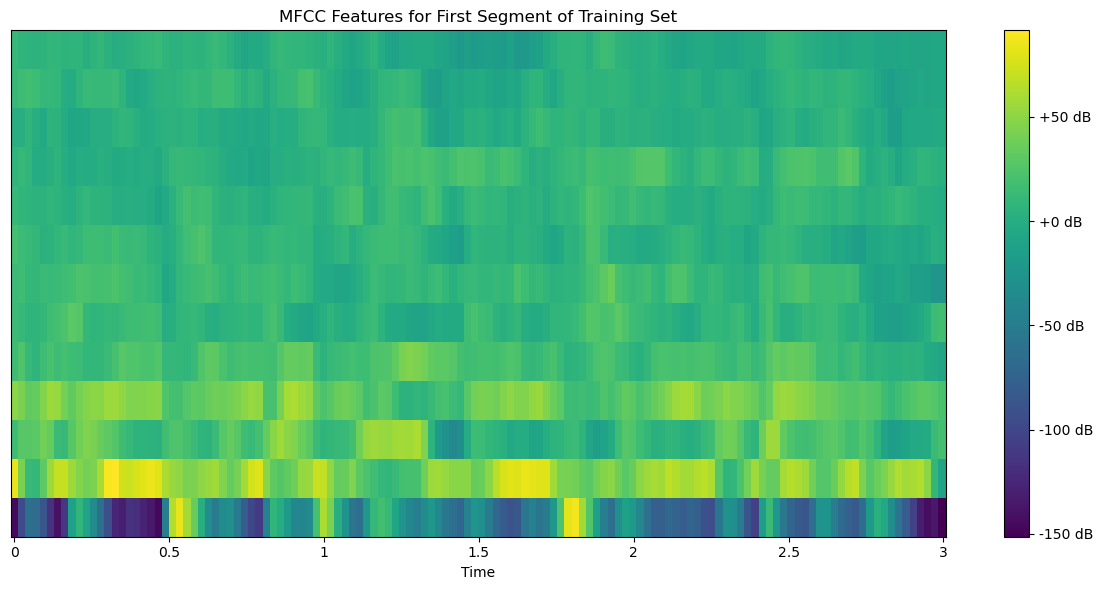

In [112]:
visualize_mfcc(X_train_lstm[0], title="MFCC Features for First Segment of Training Set")

In [113]:
print(X_train_lstm[0])

[[-145.2467      83.78412     14.795496  ...    0.5570729   11.219773
    11.092215 ]
 [ -96.32142     43.037666    27.20166   ...    1.0761685   16.446373
     6.871373 ]
 [ -62.344788    12.636805    27.427296  ...    7.086174    18.12839
     5.2111006]
 ...
 [-143.12103     49.558304    -3.1955175 ...   -5.7326903   -8.202904
    -7.433549 ]
 [-135.97768      9.318918    13.567976  ...   -4.098215    -6.806074
    -6.7163897]
 [-151.32275    -10.895248    19.050419  ...   -3.892486    -6.7800593
    -6.577338 ]]


In [114]:
# Define a custom dataset class for MFCC features
class MFCCDataset(Dataset):
    def __init__(self, features, labels):
        """
        Custom dataset for MFCC features
        
        Args:
            features: MFCC features as numpy array
            labels: Class labels as numpy array
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [115]:

# Create datasets for train, validation and test sets
train_dataset = MFCCDataset(X_train_lstm, y_train_lstm)
val_dataset = MFCCDataset(X_val_lstm, y_val_lstm)
test_dataset = MFCCDataset(X_test_lstm, y_test_lstm)

# Create dataloaders with appropriate batch size
batch_size = 32  # You can adjust this based on your needs

train_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_lstm = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set: {len(train_dataset)} segments")
print(f"Validation set: {len(val_dataset)} segments")
print(f"Test set: {len(test_dataset)} segments")

# Check the shape of feature tensors in a batch
for features, labels in train_loader_lstm:
    print(f"Feature batch shape: {features.shape}")  # Should be [batch_size, sequence_length, n_mfcc]
    print(f"Labels batch shape: {labels.shape}")     # Should be [batch_size]
    break

Training set: 13295 segments
Validation set: 3779 segments
Test set: 1898 segments
Feature batch shape: torch.Size([32, 130, 13])
Labels batch shape: torch.Size([32])


In [116]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve for a specified patience.
    
    Args:
        patience (int): How many epochs to wait after last validation loss improvement
        delta (float): Minimum change to qualify as an improvement
        path (str): Path to save the checkpoint
        verbose (bool): If True, prints a message for each validation loss improvement
    """
    def __init__(self, patience=7, delta=0, path='checkpoint.pt', verbose=True):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        
    def __call__(self, val_loss, model):
        score = -val_loss  # Higher score is better
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            # Loss didn't improve enough
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Loss improved
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        """Save model when validation loss improves"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [117]:
def train_lstm_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the LSTM model for one epoch.
    
    Args:
        model: PyTorch LSTM model
        dataloader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run the model on
        
    Returns:
        tuple: (epoch_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total
    
    return epoch_loss, accuracy

def validate_lstm(model, dataloader, criterion, device):
    """
    Validate the LSTM model.
    
    Args:
        model: PyTorch LSTM model
        dataloader: DataLoader for validation data
        criterion: Loss function
        device: Device to run the model on
        
    Returns:
        tuple: (validation_loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(dataloader)
    accuracy = correct / total
    
    return val_loss, accuracy

def train_lstm_model(model, train_loader, val_loader, test_loader, 
                    num_epochs, lr, device, experiment=None, 
                    class_names=None, patience=10, model_name='lstm'):
    """
    Train and evaluate the LSTM model with early stopping.
    
    Args:
        model: PyTorch LSTM model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        num_epochs: Maximum number of epochs to train
        lr: Learning rate
        device: Device to run on
        experiment: Comet experiment for tracking
        class_names: List of class names
        patience: Number of epochs to wait before early stopping
        model_name (str): Name for logging purposes. Defaults to 'lstm'.

    Returns:
        tuple: (model, train_losses, val_losses, train_accs, val_accs,
                test_accuracy, micro_f1, macro_f1, conf_matrix,
    """
    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    # Track metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    # Log parameters to experiment if provided
    if experiment:
        experiment.log_parameters({
            'model': model_name,
            'optimizer': 'Adam',
            'learning_rate': lr,
            'batch_size': train_loader.batch_size,
            'max_epochs': num_epochs,
            'mfcc_features': train_loader.dataset[0][0].shape[1],
            'early_stopping_patience': patience
        })
    
    print(f"Starting {model_name.upper()} training for up to {num_epochs} epochs (with early stopping)...")
    
    # Training loop
    for epoch in range(num_epochs):
        # Train
        train_loss, train_accuracy = train_lstm_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_accuracy = validate_lstm(
            model, val_loader, criterion, device
        )
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Log to experiment tracking
        if experiment:
            experiment.log_metric(f"{model_name}_train_loss", train_loss, epoch=epoch)
            experiment.log_metric(f"{model_name}_val_loss", val_loss, epoch=epoch)
            experiment.log_metric(f"{model_name}_train_accuracy", train_accuracy, epoch=epoch)
            experiment.log_metric(f"{model_name}_val_accuracy", val_accuracy, epoch=epoch)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # Test the model
      # --- Test the best model using the generic test_model function ---
    test_metric_name = f"{model_name}_test"
    test_accuracy, micro_f1, macro_f1, conf_matrix, report_str = test_model(
        model=model,
        dataloader=test_loader, # Ensure using the correct test loader
        device=device,
        class_names=class_names,
        plot_cm=True,
        experiment=experiment,
        metric_name=test_metric_name
    )
    
    actual_epochs = len(train_losses)
    
    # Report actual epochs trained
    print(f"\n{model_name.upper()} Training completed after {actual_epochs} epochs. Test accuracy: {test_accuracy*100:.2f}%")
    
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'confusion_matrix': conf_matrix,
        'classification_report': report_str
    }

    return results_dict

In [118]:
class Net5(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=2, num_classes=10):
        super(Net5, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Linear(hidden_size*2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Forward pass through LSTM layers
        # Shape: [batch_size, sequence_length, input_size]
        lstm_out, _ = self.lstm(x)
        
        # Use the last time step output
        lstm_out = lstm_out[:, -1, :]
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Classify
        output = self.fc(lstm_out)
        
        return output

Starting LSTM training for up to 50 epochs (with early stopping)...
Epoch [1/50] | Train Loss: 1.5147 | Train Acc: 45.21% | Val Loss: 1.4633 | Val Acc: 46.07%
Validation loss decreased (inf --> 1.463343). Saving model...
Epoch [2/50] | Train Loss: 1.2259 | Train Acc: 55.41% | Val Loss: 1.3145 | Val Acc: 51.65%
Validation loss decreased (1.463343 --> 1.314468). Saving model...
Epoch [3/50] | Train Loss: 1.0566 | Train Acc: 62.15% | Val Loss: 1.2919 | Val Acc: 53.82%
Validation loss decreased (1.314468 --> 1.291888). Saving model...
Epoch [4/50] | Train Loss: 0.9344 | Train Acc: 67.04% | Val Loss: 1.3153 | Val Acc: 55.57%
EarlyStopping counter: 1 out of 10
Epoch [5/50] | Train Loss: 0.8281 | Train Acc: 71.06% | Val Loss: 1.3618 | Val Acc: 55.89%
EarlyStopping counter: 2 out of 10
Epoch [6/50] | Train Loss: 0.7483 | Train Acc: 73.53% | Val Loss: 1.2687 | Val Acc: 58.80%
Validation loss decreased (1.291888 --> 1.268699). Saving model...
Epoch [7/50] | Train Loss: 0.6566 | Train Acc: 77.04%

/var/folders/pt/69g6_jnn3jn_02xm4dfl99_80000gn/T/ipykernel_5538/2719184646.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint

--------------------------------------------------------------------------------
Test Results (lstm_test):
--------------------------------------------------------------------------------
Overall Test Accuracy : 67.60%
Micro F1 Score        : 0.6760
Macro F1 Score        : 0.6681

Classification Report:
              precision    recall  f1-score   support

         pop     0.8226    0.8053    0.8138       190
       metal     0.6172    0.9421    0.7458       190
       disco     0.6532    0.5947    0.6226       190
       blues     0.7661    0.5000    0.6051       190
      reggae     0.7851    0.5000    0.6109       190
   classical     0.8832    0.9947    0.9356       190
        rock     0.4061    0.3545    0.3785       189
      hiphop     0.4854    0.6105    0.5408       190
     country     0.6047    0.5503    0.5762       189
        jazz     0.8037    0.9053    0.8515       190

    accuracy                         0.6760      1898
   macro avg     0.6827    0.6757    0.6681  

<Figure size 1200x800 with 0 Axes>

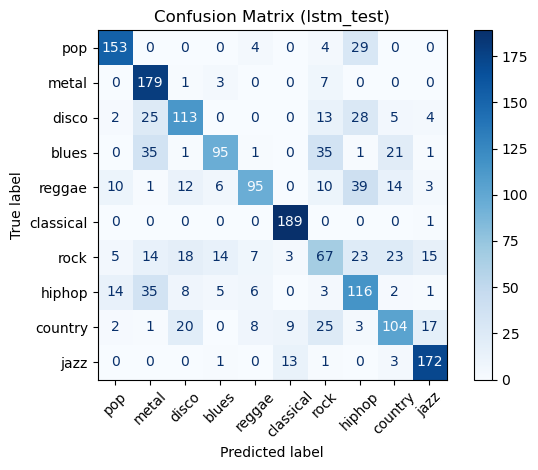


LSTM Training completed after 17 epochs. Test accuracy: 67.60%


In [119]:
lstm_model = Net5(
    input_size=X_train_lstm.shape[2],  # Number of MFCC features
    hidden_size=128,
    num_layers=2,
    num_classes=NUM_CLASSES
).to(device)

net5_results = train_lstm_model(
    lstm_model,
    train_loader_lstm,
    val_loader_lstm,
    test_loader_lstm,
    num_epochs=50,
    lr=0.001,
    device=device,
    experiment=experiment,
    class_names=[id_to_genre[i] for i in range(NUM_CLASSES)]
)

## Net 6 - LSTM With Addition GAN Generated Audio Samples


### Helper Functions

In [120]:
def mfcc_to_audio(mfcc_features, sr=22050, n_fft=2048, hop_length=512, n_mels=128, n_iter=50):
    """
    Convert MFCC features back to audio (approximation).
    
    Args:
        mfcc_features: MFCC features (time x n_mfcc)
        sr: Sample rate
        n_fft: FFT window size
        hop_length: Hop size
        n_mels: Number of mel bands
        n_iter: Griffin-Lim iterations
        
    Returns:
        y: Audio signal (approximate reconstruction)
    """
    # Convert to numpy if tensor
    if torch.is_tensor(mfcc_features):
        mfcc_features = mfcc_features.cpu().numpy()
    
    # We need to reshape to (n_mfcc, time)
    if len(mfcc_features.shape) > 2:
        # Handle batch dimension by taking first example
        mfcc_features = mfcc_features[0]
    
    mfcc_features = mfcc_features.T  # Convert to (n_mfcc, time)
    
    # Only use base MFCCs (not deltas)
    if mfcc_features.shape[0] > 20:
        base_mfccs = mfcc_features[:20]
    else:
        base_mfccs = mfcc_features
    
    # Inverse MFCC to get approximate mel spectrogram
    mel_spec = librosa.feature.inverse.mfcc_to_mel(
        mfcc=base_mfccs, 
        n_mels=n_mels,
        dct_type=2,
        norm='ortho',
        ref=1.0
    )
    
    # Convert from dB to power
    mel_spec = librosa.db_to_power(mel_spec)
    
    # Approximate waveform using Griffin-Lim
    y = librosa.feature.inverse.mel_to_audio(
        mel_spec, 
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=n_iter
    )
    
    return y

In [121]:
def generate_and_save_audio_from_mfcc(mfcc_tensor, filename, sr=22050):
    """
    Generate audio from MFCC features and save to file.
    
    Args:
        mfcc_tensor: Tensor of MFCC features
        filename: Output filename
        sr: Sample rate
    """
    # Convert MFCC to audio
    audio = mfcc_to_audio(mfcc_tensor)
    
    # Save audio file
    sf.write(filename, audio, sr)
    
    return audio


def plot_mfcc_comparison(original_mfcc, generated_mfcc, titles=["Original MFCC", "Generated MFCC"]):
    """
    Plot original and generated MFCC features side by side.
    
    Args:
        original_mfcc: Original MFCC features (time x features)
        generated_mfcc: Generated MFCC features (time x features)
        titles: Titles for the plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Convert tensors to numpy
    if torch.is_tensor(original_mfcc):
        original_mfcc = original_mfcc.cpu().numpy()
    if torch.is_tensor(generated_mfcc):
        generated_mfcc = generated_mfcc.detach().cpu().numpy()
    
    # Handle batch dimension
    if len(original_mfcc.shape) > 2:
        original_mfcc = original_mfcc[0]
    if len(generated_mfcc.shape) > 2:
        generated_mfcc = generated_mfcc[0]
    
    # Plot original MFCC
    librosa.display.specshow(
        original_mfcc.T,
        x_axis='time',
        sr=22050,
        hop_length=512,
        ax=axes[0],
        cmap='viridis'
    )
    axes[0].set_title(titles[0])
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('MFCC Coefficients')
    
    # Plot generated MFCC
    librosa.display.specshow(
        generated_mfcc.T,
        x_axis='time',
        sr=22050,
        hop_length=512,
        ax=axes[1],
        cmap='viridis'
    )
    axes[1].set_title(titles[1])
    axes[1].set_xlabel('Time')
    
    plt.tight_layout()
    return fig


### GAN Models

In [122]:
# GAN model for generating MFCC features
class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=10, output_dim=60, seq_len=300):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.output_dim = output_dim
        self.seq_len = seq_len
        
        self.label_embedding = nn.Embedding(label_dim, 50)
        
        self.main = nn.Sequential(
            nn.Linear(noise_dim + 50, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, seq_len * output_dim),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        
        # Concatenate noise and label embedding
        x = torch.cat([z, label_embedding], dim=1)
        
        # Generate data
        x = self.main(x)
        
        # Reshape to sequence format [batch, seq_len, features]
        x = x.view(x.size(0), self.seq_len, self.output_dim)
        
        return x


In [123]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=60, seq_len=300, label_dim=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        
        # Label embedding
        self.label_embedding = nn.Embedding(label_dim, 50)
        
        # Main network
        self.main = nn.Sequential(
            nn.Flatten(),  # Flatten the sequence
            nn.Linear(seq_len * input_dim + 50, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        # x input shape: [batch, seq_len, input_dim]
        
        # Embed labels
        label_embedding = self.label_embedding(labels)
        
        # Flatten input
        x = x.view(x.size(0), -1)
        
        # Concatenate with label embedding
        x = torch.cat([x, label_embedding], dim=1)
        
        # Discriminator output
        return self.main(x)



### GAN Training Functions

In [ ]:
def weights_init(m):
    """Initialize network weights for better GAN training"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def save_generated_mfcc_as_audio(generator, epoch, noise_dim=100, num_samples=5, 
                               output_dir="gan_samples", device=device):
    """
    Save generated MFCC samples as audio files.
    
    Args:
        generator (nn.Module): Trained generator model
        epoch (int): Current training epoch
        noise_dim (int): Dimension of noise vector
        num_samples (int): Number of samples to generate
        output_dir (str): Output directory for samples
        device (torch.device): Device to run generation on
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    epoch_dir = os.path.join(output_dir, f"epoch_{epoch}")
    os.makedirs(epoch_dir, exist_ok=True)
    
    # Set generator to eval mode
    generator.eval()
    
    # Create fixed labels - one for each genre
    labels = torch.arange(10, device=device)  # Assumes 10 genres
    
    # Create fixed noise
    z = torch.randn(10, noise_dim, device=device)
    
    # Generate samples
    with torch.no_grad():
        fake_mfccs = generator(z, labels)
    
    # For each genre, save visualization and audio
    for i in range(len(labels)):
        genre_idx = labels[i].item()
        sample = fake_mfccs[i]
        
        # Save MFCC visualization
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            sample.cpu().numpy().T,
            x_axis='time',
            sr=22050,
            hop_length=512,
            cmap='viridis'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Generated MFCC - Genre {genre_idx}')
        plt.tight_layout()
        plt.savefig(os.path.join(epoch_dir, f'mfcc_genre_{genre_idx}.png'))
        plt.close()
        
        # Convert to audio and save
        audio_path = os.path.join(epoch_dir, f'audio_genre_{genre_idx}.wav')
        try:
            audio = generate_and_save_audio_from_mfcc(sample, audio_path)
            print(f"Generated audio for genre {genre_idx}")
        except Exception as e:
            print(f"Error generating audio for genre {genre_idx}: {e}")
    
    print(f"Generated samples saved to {epoch_dir}")
    generator.train()  # Return to training mode


def train_gan_with_audio_samples(generator, discriminator, dataloader, epochs=60, noise_dim=100,
                               batch_size=32, device=device, save_dir="gan_checkpoints",
                               save_audio_interval=10):
    """
    Train GAN model for MFCC feature generation and save audio samples periodically.
    
    Args:
        generator: Generator model
        discriminator: Discriminator model
        dataloader: DataLoader containing training data
        epochs: Number of training epochs
        noise_dim: Dimension of noise vector input
        batch_size: Batch size for training
        device: Device to run training on (cuda/mps/cpu)
        save_dir: Directory to save model checkpoints and samples
        save_audio_interval: Interval to save audio samples
    
    Returns:
        tuple: (trained_generator, trained_discriminator, g_losses, d_losses)
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Configure optimizers with recommended GAN parameters
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    # Binary cross-entropy loss for GAN training
    criterion = nn.BCELoss()
    
    # Create consistent noise vectors for monitoring progress
    fixed_noise = torch.randn(10, noise_dim).to(device)
    fixed_labels = torch.arange(0, 10).to(device)  # One sample per genre
    
    # Loss tracking
    g_losses = []
    d_losses = []
    
    # Detection of optimal generator states
    optimal_d_g_ratio = 0
    d_g_gap_threshold = 0.6
    
    # Timing
    training_start = time.time()
    
    # Labels for loss calculation
    real_label = 1.0
    fake_label = 0.0
    
    for epoch in range(epochs):
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        batches = 0
        
        # Process all batches
        for real_data, labels in dataloader:
            current_batch = real_data.size(0)
            batches += 1
            
            # Move tensors to device
            real_data = real_data.to(device)
            labels = labels.to(device)
            
            optimizer_d.zero_grad()
            
            # Process real samples
            real_targets = torch.full((current_batch, 1), real_label, dtype=torch.float, device=device)
            d_output_real = discriminator(real_data, labels)
            d_real_loss = criterion(d_output_real, real_targets)
            d_real_loss.backward()
            
            # Process fake samples
            z = torch.randn(current_batch, noise_dim, device=device)
            fake_samples = generator(z, labels)
            fake_targets = torch.full((current_batch, 1), fake_label, dtype=torch.float, device=device)
            d_output_fake = discriminator(fake_samples.detach(), labels)
            d_fake_loss = criterion(d_output_fake, fake_targets)
            d_fake_loss.backward()
            
            # Combined loss and update
            d_loss = d_real_loss + d_fake_loss
            optimizer_d.step()
            
            optimizer_g.zero_grad()
            
            # Generator try to trick discriminator
            gen_targets = torch.full((current_batch, 1), real_label, dtype=torch.float, device=device)
            d_output_gen = discriminator(fake_samples, labels)
            g_loss = criterion(d_output_gen, gen_targets)
            g_loss.backward()
            optimizer_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
        
        # Calculate average epoch losses
        avg_g_loss = epoch_g_loss / batches
        avg_d_loss = epoch_d_loss / batches
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        # Epoch summary
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Generator: {avg_g_loss:.4f} | Discriminator: {avg_d_loss:.4f}")
        
        # Check for favorable generator state (D loss > G loss)
        if avg_d_loss > avg_g_loss and (avg_d_loss - avg_g_loss) > d_g_gap_threshold:
            current_ratio = avg_d_loss / max(avg_g_loss, 1e-5)
            
            # If this is our best state so far, save it
            if current_ratio > optimal_d_g_ratio:
                optimal_d_g_ratio = current_ratio
                print(f"✓ Generator showing excellent performance! D/G ratio: {current_ratio:.2f}")
                
                # Save this promising model
                checkpoint_path = os.path.join(save_dir, f"gan_optimal_e{epoch+1}_r{current_ratio:.2f}.pt")
                torch.save({
                    'epoch': epoch + 1,
                    'generator': generator.state_dict(),
                    'discriminator': discriminator.state_dict(),
                    'g_loss': avg_g_loss,
                    'd_loss': avg_d_loss,
                    'ratio': current_ratio
                }, checkpoint_path)
                
                # Generate audio samples from this promising state
                optimal_samples_dir = os.path.join(save_dir, "optimal_samples")
                save_generated_mfcc_as_audio(
                    generator=generator,
                    epoch=f"{epoch+1}_optimal",
                    noise_dim=noise_dim,
                    output_dir=optimal_samples_dir
                )
        
        # Regular checkpoints and audio samples
        if (epoch + 1) % save_audio_interval == 0 or epoch == epochs - 1:
            # Generate and save samples
            samples_dir = os.path.join(save_dir, f"samples_epoch{epoch+1}")
            save_generated_mfcc_as_audio(
                generator=generator,
                epoch=epoch+1,
                noise_dim=noise_dim,
                output_dir=samples_dir
            )
            
            # Save checkpoint
            checkpoint_path = os.path.join(save_dir, f"gan_epoch{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_loss': avg_g_loss,
                'd_loss': avg_d_loss
            }, checkpoint_path)
    
    # Visualize training progression
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Progress')
    plt.savefig(os.path.join(save_dir, "gan_loss_graph.png"))
    plt.show()
    
    # Save final models
    torch.save({
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict()
    }, os.path.join(save_dir, "gan_final_models.pt"))
    
    training_time = (time.time() - training_start) / 60
    print(f"GAN training completed in {training_time:.1f} minutes")
    if optimal_d_g_ratio > 0:
        print(f"Best generator performance had D/G ratio of {optimal_d_g_ratio:.2f}")
    
    return generator, discriminator, g_losses, d_losses


In [125]:


def generate_synthetic_data(generator, num_samples_per_class=100, num_classes=10, 
                           noise_dim=100, device=device):
    """Generate synthetic data using the trained generator"""
    generator.eval()
    generator.to(device)
    
    all_samples = []
    all_labels = []
    
    # Generate samples for each class
    for class_idx in range(num_classes):
        # Create labels tensor
        labels = torch.full((num_samples_per_class,), class_idx, dtype=torch.long).to(device)
        
        # Create noise vector
        z = torch.randn(num_samples_per_class, noise_dim).to(device)
        
        # Generate samples
        with torch.no_grad():
            fake_samples = generator(z, labels)
        
        # Store samples and labels
        all_samples.append(fake_samples.cpu())
        all_labels.append(labels.cpu())
    
    # Concatenate all samples and labels
    all_samples = torch.cat(all_samples, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_samples, all_labels

Beginning GAN training for 50 epochs...


Epoch 1/50: 100%|██████████| 416/416 [00:22<00:00, 18.47it/s]


Epoch 1/50 | Generator: 2.6534 | Discriminator: 0.4329 | Runtime: 0.4 min


Epoch 2/50: 100%|██████████| 416/416 [00:05<00:00, 76.48it/s]


Epoch 2/50 | Generator: 7.6627 | Discriminator: 0.0307 | Runtime: 0.5 min


Epoch 3/50: 100%|██████████| 416/416 [00:05<00:00, 78.72it/s]


Epoch 3/50 | Generator: 9.0061 | Discriminator: 0.0277 | Runtime: 0.6 min


Epoch 4/50: 100%|██████████| 416/416 [00:04<00:00, 86.95it/s]


Epoch 4/50 | Generator: 10.8461 | Discriminator: 0.0001 | Runtime: 0.6 min


Epoch 5/50: 100%|██████████| 416/416 [00:05<00:00, 71.88it/s]


Epoch 5/50 | Generator: 11.7422 | Discriminator: 0.0000 | Runtime: 0.7 min


Epoch 6/50: 100%|██████████| 416/416 [00:05<00:00, 77.02it/s]


Epoch 6/50 | Generator: 12.2611 | Discriminator: 0.0000 | Runtime: 0.8 min


Epoch 7/50: 100%|██████████| 416/416 [00:04<00:00, 84.29it/s]


Epoch 7/50 | Generator: 12.6442 | Discriminator: 0.0000 | Runtime: 0.9 min


Epoch 8/50: 100%|██████████| 416/416 [00:04<00:00, 86.35it/s]


Epoch 8/50 | Generator: 13.0075 | Discriminator: 0.0000 | Runtime: 1.0 min


Epoch 9/50: 100%|██████████| 416/416 [00:04<00:00, 88.12it/s]


Epoch 9/50 | Generator: 13.3225 | Discriminator: 0.0000 | Runtime: 1.1 min


Epoch 10/50: 100%|██████████| 416/416 [00:04<00:00, 85.53it/s]


Epoch 10/50 | Generator: 13.6219 | Discriminator: 0.0000 | Runtime: 1.1 min
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/samples_epoch10/epoch_10


Epoch 11/50: 100%|██████████| 416/416 [00:05<00:00, 72.52it/s]


Epoch 11/50 | Generator: 13.9161 | Discriminator: 0.0000 | Runtime: 1.4 min


Epoch 12/50: 100%|██████████| 416/416 [00:04<00:00, 83.88it/s]


Epoch 12/50 | Generator: 14.1949 | Discriminator: 0.0000 | Runtime: 1.4 min


Epoch 13/50: 100%|██████████| 416/416 [00:05<00:00, 81.84it/s]


Epoch 13/50 | Generator: 14.4177 | Discriminator: 0.0000 | Runtime: 1.5 min


Epoch 14/50: 100%|██████████| 416/416 [00:04<00:00, 87.77it/s]


Epoch 14/50 | Generator: 24.8949 | Discriminator: 21.2761 | Runtime: 1.6 min


Epoch 15/50: 100%|██████████| 416/416 [00:04<00:00, 87.71it/s]


Epoch 15/50 | Generator: 49.1775 | Discriminator: 100.0001 | Runtime: 1.7 min
✓ Generator showing excellent performance! D/G ratio: 2.03
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/optimal_samples/epoch_15_optimal


Epoch 16/50: 100%|██████████| 416/416 [00:06<00:00, 67.89it/s]


Epoch 16/50 | Generator: 26.5287 | Discriminator: 100.0000 | Runtime: 1.9 min
✓ Generator showing excellent performance! D/G ratio: 3.77
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/optimal_samples/epoch_16_optimal


Epoch 17/50: 100%|██████████| 416/416 [00:07<00:00, 57.93it/s]


Epoch 17/50 | Generator: 22.9833 | Discriminator: 100.0000 | Runtime: 2.1 min
✓ Generator showing excellent performance! D/G ratio: 4.35
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/optimal_samples/epoch_17_optimal


Epoch 18/50: 100%|██████████| 416/416 [00:05<00:00, 74.81it/s]


Epoch 18/50 | Generator: 23.8999 | Discriminator: 100.0000 | Runtime: 2.3 min


Epoch 19/50: 100%|██████████| 416/416 [00:05<00:00, 78.33it/s]


Epoch 19/50 | Generator: 23.7656 | Discriminator: 100.0000 | Runtime: 2.4 min


Epoch 20/50: 100%|██████████| 416/416 [00:05<00:00, 77.89it/s]


Epoch 20/50 | Generator: 23.9216 | Discriminator: 100.0000 | Runtime: 2.5 min
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/samples_epoch20/epoch_20


Epoch 21/50: 100%|██████████| 416/416 [00:05<00:00, 75.88it/s]


Epoch 21/50 | Generator: 24.9647 | Discriminator: 100.0000 | Runtime: 2.7 min


Epoch 22/50: 100%|██████████| 416/416 [00:05<00:00, 79.43it/s]


Epoch 22/50 | Generator: 25.2560 | Discriminator: 100.0000 | Runtime: 2.8 min


Epoch 23/50: 100%|██████████| 416/416 [00:05<00:00, 79.11it/s]


Epoch 23/50 | Generator: 24.9135 | Discriminator: 100.0000 | Runtime: 2.9 min


Epoch 24/50: 100%|██████████| 416/416 [00:06<00:00, 69.08it/s]


Epoch 24/50 | Generator: 24.3336 | Discriminator: 100.0000 | Runtime: 3.0 min


Epoch 25/50: 100%|██████████| 416/416 [00:05<00:00, 76.72it/s]


Epoch 25/50 | Generator: 24.0309 | Discriminator: 100.0000 | Runtime: 3.1 min


Epoch 26/50: 100%|██████████| 416/416 [00:05<00:00, 77.91it/s]


Epoch 26/50 | Generator: 24.5553 | Discriminator: 100.0000 | Runtime: 3.1 min


Epoch 27/50: 100%|██████████| 416/416 [00:05<00:00, 81.97it/s]


Epoch 27/50 | Generator: 24.8070 | Discriminator: 100.0000 | Runtime: 3.2 min


Epoch 28/50: 100%|██████████| 416/416 [00:05<00:00, 73.81it/s]


Epoch 28/50 | Generator: 25.1059 | Discriminator: 100.0000 | Runtime: 3.3 min


Epoch 29/50: 100%|██████████| 416/416 [00:05<00:00, 69.90it/s]


Epoch 29/50 | Generator: 25.7847 | Discriminator: 100.0000 | Runtime: 3.4 min


Epoch 30/50: 100%|██████████| 416/416 [00:05<00:00, 73.72it/s]


Epoch 30/50 | Generator: 25.7824 | Discriminator: 100.0000 | Runtime: 3.5 min
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/samples_epoch30/epoch_30


Epoch 31/50: 100%|██████████| 416/416 [00:05<00:00, 71.55it/s]


Epoch 31/50 | Generator: 25.9660 | Discriminator: 100.0000 | Runtime: 3.7 min


Epoch 32/50: 100%|██████████| 416/416 [00:04<00:00, 85.03it/s]


Epoch 32/50 | Generator: 26.5262 | Discriminator: 100.0000 | Runtime: 3.8 min


Epoch 33/50: 100%|██████████| 416/416 [00:04<00:00, 88.40it/s]


Epoch 33/50 | Generator: 26.5362 | Discriminator: 100.0000 | Runtime: 3.9 min


Epoch 34/50: 100%|██████████| 416/416 [00:04<00:00, 86.99it/s]


Epoch 34/50 | Generator: 26.6472 | Discriminator: 100.0000 | Runtime: 4.0 min


Epoch 35/50: 100%|██████████| 416/416 [00:04<00:00, 83.23it/s]


Epoch 35/50 | Generator: 26.8098 | Discriminator: 100.0000 | Runtime: 4.1 min


Epoch 36/50: 100%|██████████| 416/416 [00:04<00:00, 87.29it/s]


Epoch 36/50 | Generator: 26.9689 | Discriminator: 100.0000 | Runtime: 4.1 min


Epoch 37/50: 100%|██████████| 416/416 [00:04<00:00, 88.42it/s]


Epoch 37/50 | Generator: 26.2442 | Discriminator: 100.0000 | Runtime: 4.2 min


Epoch 38/50: 100%|██████████| 416/416 [00:05<00:00, 82.51it/s]


Epoch 38/50 | Generator: 26.6244 | Discriminator: 100.0000 | Runtime: 4.3 min


Epoch 39/50: 100%|██████████| 416/416 [00:04<00:00, 84.24it/s]


Epoch 39/50 | Generator: 27.3411 | Discriminator: 100.0000 | Runtime: 4.4 min


Epoch 40/50: 100%|██████████| 416/416 [00:04<00:00, 88.32it/s]


Epoch 40/50 | Generator: 27.5668 | Discriminator: 100.0000 | Runtime: 4.5 min
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/samples_epoch40/epoch_40


Epoch 41/50: 100%|██████████| 416/416 [00:05<00:00, 69.87it/s]


Epoch 41/50 | Generator: 27.1515 | Discriminator: 100.0000 | Runtime: 4.7 min


Epoch 42/50: 100%|██████████| 416/416 [00:04<00:00, 92.30it/s]


Epoch 42/50 | Generator: 27.3099 | Discriminator: 100.0000 | Runtime: 4.8 min


Epoch 43/50: 100%|██████████| 416/416 [00:04<00:00, 89.84it/s]


Epoch 43/50 | Generator: 27.5941 | Discriminator: 100.0000 | Runtime: 4.8 min


Epoch 44/50: 100%|██████████| 416/416 [00:04<00:00, 92.11it/s]


Epoch 44/50 | Generator: 27.9599 | Discriminator: 100.0000 | Runtime: 4.9 min


Epoch 45/50: 100%|██████████| 416/416 [00:04<00:00, 91.14it/s]


Epoch 45/50 | Generator: 27.7319 | Discriminator: 100.0000 | Runtime: 5.0 min


Epoch 46/50: 100%|██████████| 416/416 [00:04<00:00, 90.58it/s]


Epoch 46/50 | Generator: 27.3235 | Discriminator: 100.0000 | Runtime: 5.1 min


Epoch 47/50: 100%|██████████| 416/416 [00:05<00:00, 78.28it/s]


Epoch 47/50 | Generator: 23.6536 | Discriminator: 100.0000 | Runtime: 5.2 min


Epoch 48/50: 100%|██████████| 416/416 [00:05<00:00, 80.29it/s]


Epoch 48/50 | Generator: 22.3061 | Discriminator: 100.0000 | Runtime: 5.2 min
✓ Generator showing excellent performance! D/G ratio: 4.48
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/optimal_samples/epoch_48_optimal


Epoch 49/50: 100%|██████████| 416/416 [00:05<00:00, 80.88it/s]


Epoch 49/50 | Generator: 22.6727 | Discriminator: 100.0000 | Runtime: 5.4 min


Epoch 50/50: 100%|██████████| 416/416 [00:04<00:00, 89.70it/s]


Epoch 50/50 | Generator: 22.9789 | Discriminator: 100.0000 | Runtime: 5.5 min
Generated audio for genre 0
Generated audio for genre 1
Generated audio for genre 2
Generated audio for genre 3
Generated audio for genre 4
Generated audio for genre 5
Generated audio for genre 6
Generated audio for genre 7
Generated audio for genre 8
Generated audio for genre 9
Generated samples saved to gan_checkpoints/samples_epoch50/epoch_50


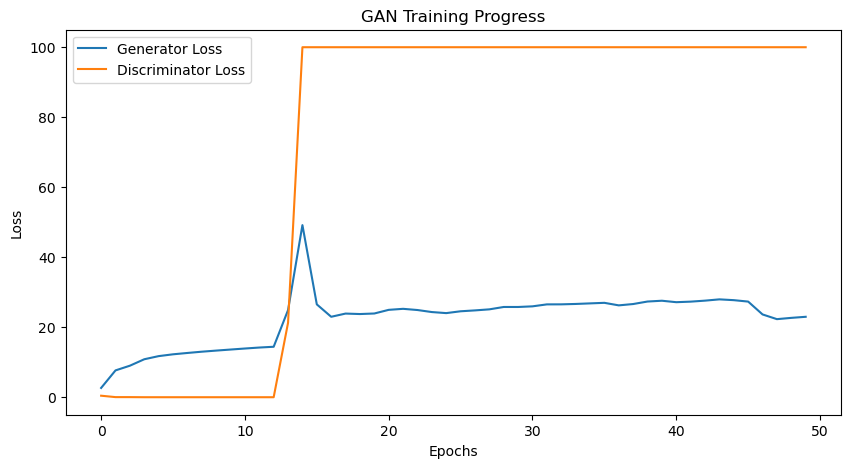

GAN training completed in 5.6 minutes
Best generator performance had D/G ratio of 4.48
Generated audio has been saved to 'generated_sample_genre0.wav'


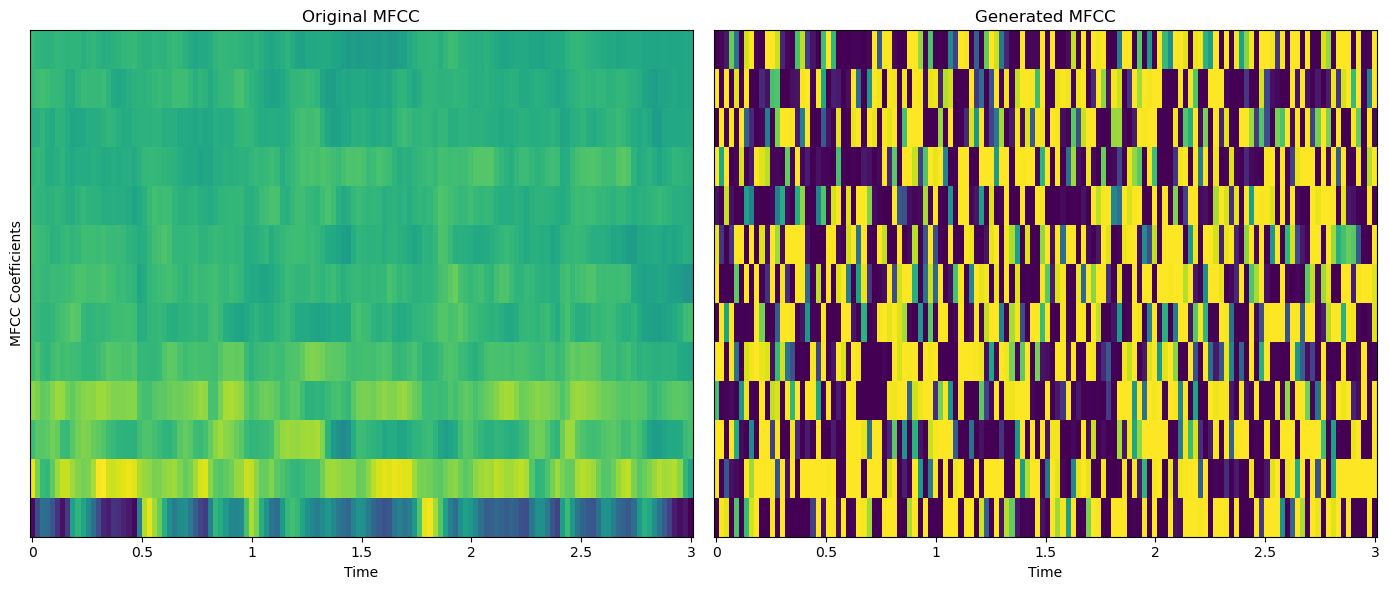

In [126]:
# Example usage in your notebook:
# Initialize a GAN for MFCC generation

# First, determine input dimensions from your LSTM data
n_mfcc = X_train_lstm.shape[2]  # Number of MFCC features
seq_len = X_train_lstm.shape[1]  # Sequence length
num_classes = len(np.unique(y_train_lstm))  # Number of genres

noise_dim = 100  # Size of noise vector

# Create GAN models
generator = Generator(
    noise_dim=noise_dim,
    label_dim=num_classes,
    output_dim=n_mfcc,  # Match MFCC feature dimension
    seq_len=seq_len     # Match sequence length
).to(device)

discriminator = Discriminator(
    input_dim=n_mfcc,
    seq_len=seq_len,
    label_dim=num_classes
).to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Train the GAN - Note: Reuse your existing train_loader_lstm or create a new one
# In this example, we'll use a shorter training period for demonstration (10 epochs)
gan_epochs = 50
save_audio_every = 10  # Save audio samples every 2 epochs

generator, discriminator, g_losses, d_losses = train_gan_with_audio_samples(
    generator,
    discriminator,
    train_loader_lstm,
    epochs=gan_epochs,
    noise_dim=noise_dim,
    device=device,
    save_audio_interval=save_audio_every
)

# Now you have a trained GAN that can generate MFCC features
# The training process has already saved audio samples at specified intervals

# Generate some examples for demonstration
with torch.no_grad():
    # Generate one sample for each genre
    z = torch.randn(num_classes, noise_dim).to(device)
    labels = torch.arange(num_classes).to(device)
    fake_mfccs = generator(z, labels)

# Show the first generated MFCC and compare to a real one
real_sample = X_train_lstm[0]
generated_sample = fake_mfccs[0].cpu()

# Plot comparison
plot_mfcc_comparison(
    real_sample,
    generated_sample,
    titles=["Original MFCC", "Generated MFCC"]
)

# Generate and save audio from this MFCC
generate_and_save_audio_from_mfcc(
    generated_sample, 
    filename="generated_sample_genre0.wav"
)

print("Generated audio has been saved to 'generated_sample_genre0.wav'")

Generated 1000 synthetic MFCC samples
Shape of synthetic data: torch.Size([1000, 130, 13])


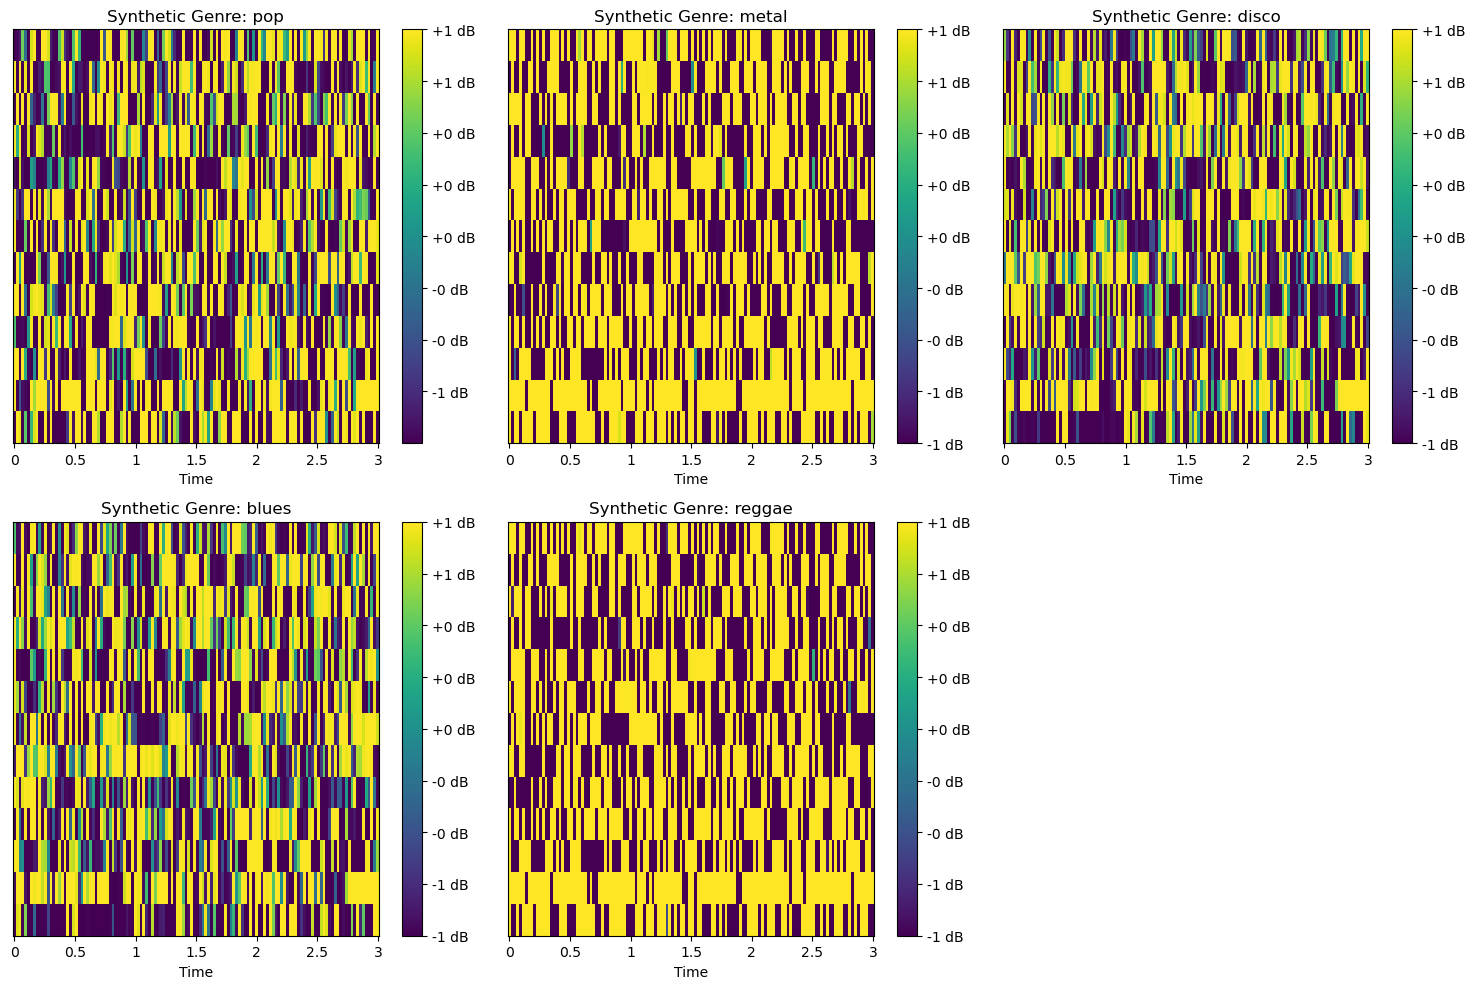

In [127]:
# Generate synthetic data - 100 samples per genre
num_samples_per_class = 100
synthetic_mfccs, synthetic_labels = generate_synthetic_data(
    generator=generator,
    num_samples_per_class=num_samples_per_class,
    num_classes=num_classes,
    noise_dim=noise_dim,
    device=device
)

print(f"Generated {len(synthetic_mfccs)} synthetic MFCC samples")
print(f"Shape of synthetic data: {synthetic_mfccs.shape}")
# Visualize a few synthetic samples
plt.figure(figsize=(15, 10))
for i in range(5):
    genre_idx = i
    # Find indices where labels match the current genre
    genre_indices = (synthetic_labels == genre_idx).nonzero(as_tuple=True)[0]
    
    if len(genre_indices) > 0:
        sample_idx = genre_indices[0]
        plt.subplot(2, 3, i+1)
        librosa.display.specshow(
            synthetic_mfccs[sample_idx].numpy().T,
            x_axis='time',
            sr=22050,
            hop_length=512,
            cmap='viridis'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Synthetic Genre: {id_to_genre[genre_idx]}')

plt.tight_layout()
plt.show()

In [128]:

# Create a combined dataset with real and synthetic data for training
# First, convert real data to PyTorch tensors if needed
X_train_tensor = torch.FloatTensor(X_train_lstm)
y_train_tensor = torch.LongTensor(y_train_lstm)

# Combine real and synthetic data
net6_X_train = torch.cat([X_train_tensor, synthetic_mfccs], dim=0)
net6_y_train = torch.cat([y_train_tensor, synthetic_labels], dim=0)

print(f"Original training data: {X_train_tensor.shape[0]} samples")
print(f"Synthetic data: {synthetic_mfccs.shape[0]} samples")
print(f"Combined data: {net6_X_train.shape[0]} samples")

# Create custom datasets and dataloaders
net6_train_dataset = MFCCDataset(net6_X_train.numpy(), net6_y_train.numpy())
net6_train_loader = DataLoader(net6_train_dataset, batch_size=batch_size, shuffle=True)

Original training data: 13295 samples
Synthetic data: 1000 samples
Combined data: 14295 samples



Class distribution in augmented dataset:
pop: 1430 samples
metal: 1430 samples
disco: 1430 samples
blues: 1430 samples
reggae: 1430 samples
classical: 1428 samples
rock: 1430 samples
hiphop: 1429 samples
country: 1428 samples
jazz: 1430 samples

Training LSTM model with augmented data...
Starting LSTM training for up to 50 epochs (with early stopping)...
Epoch [1/50] | Train Loss: 1.4856 | Train Acc: 46.02% | Val Loss: 1.4366 | Val Acc: 46.84%
Validation loss decreased (inf --> 1.436631). Saving model...
Epoch [2/50] | Train Loss: 1.1747 | Train Acc: 57.10% | Val Loss: 1.3349 | Val Acc: 52.00%
Validation loss decreased (1.436631 --> 1.334912). Saving model...
Epoch [3/50] | Train Loss: 1.0430 | Train Acc: 61.43% | Val Loss: 1.3080 | Val Acc: 53.64%
Validation loss decreased (1.334912 --> 1.307973). Saving model...
Epoch [4/50] | Train Loss: 0.8963 | Train Acc: 67.93% | Val Loss: 1.2832 | Val Acc: 55.99%
Validation loss decreased (1.307973 --> 1.283219). Saving model...
Epoch [5/50] | 

/var/folders/pt/69g6_jnn3jn_02xm4dfl99_80000gn/T/ipykernel_5538/2719184646.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint

--------------------------------------------------------------------------------
Test Results (lstm_test):
--------------------------------------------------------------------------------
Overall Test Accuracy : 66.17%
Micro F1 Score        : 0.6617
Macro F1 Score        : 0.6626

Classification Report:
              precision    recall  f1-score   support

         pop     0.7836    0.7053    0.7424       190
       metal     0.8727    0.7579    0.8113       190
       disco     0.4037    0.7947    0.5355       190
       blues     0.7158    0.6895    0.7024       190
      reggae     0.6645    0.5421    0.5971       190
   classical     0.9487    0.9737    0.9610       190
        rock     0.3737    0.3757    0.3747       189
      hiphop     0.7500    0.4737    0.5806       190
     country     0.6529    0.4180    0.5097       189
        jazz     0.7500    0.8842    0.8116       190

    accuracy                         0.6617      1898
   macro avg     0.6916    0.6615    0.6626  

<Figure size 1200x800 with 0 Axes>

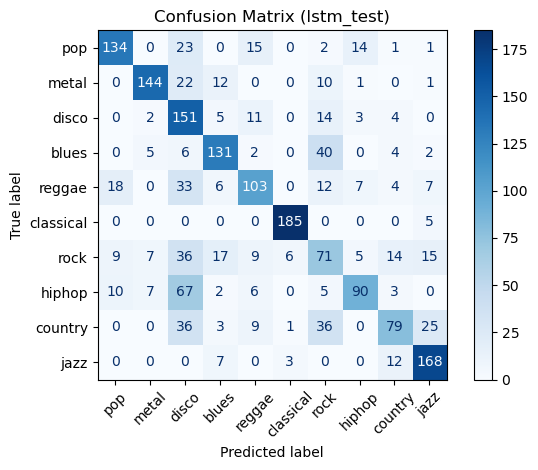


LSTM Training completed after 19 epochs. Test accuracy: 66.17%

Comparison of LSTM models:
Augmented LSTM test accuracy: 66.17%


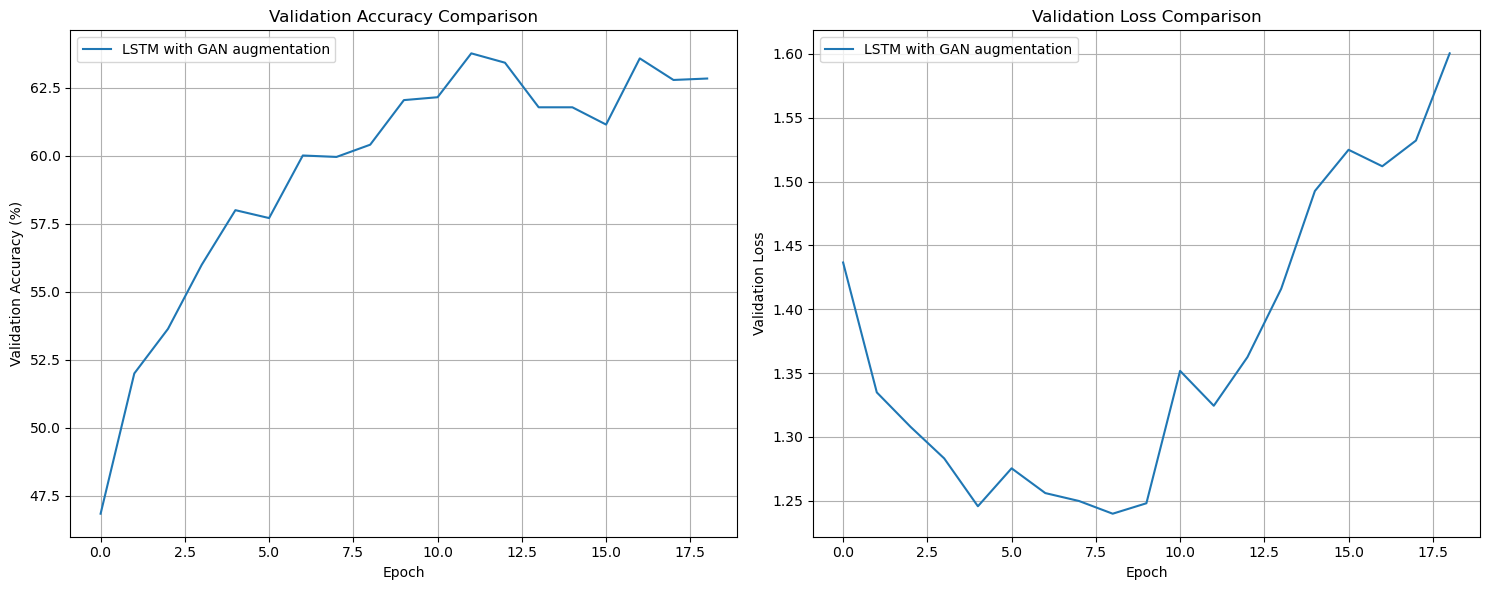

In [129]:
# Create a new LSTM model for training with augmented data
Net6 = Net5(
    input_size=X_train_lstm.shape[2],  # Number of MFCC features
    hidden_size=128,
    num_layers=2,
    num_classes=NUM_CLASSES
).to(device)

# Check class distribution in augmented dataset
genre_counts = {}
for genre_id in range(num_classes):
    count = (net6_y_train == genre_id).sum().item()
    genre_name = id_to_genre[genre_id]
    genre_counts[genre_name] = count

print("\nClass distribution in augmented dataset:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count} samples")

# Train the model with augmented data
print("\nTraining LSTM model with augmented data...")
net6_results = train_lstm_model(
    Net6,
    net6_train_loader,      # Using augmented training data
    val_loader_lstm,             # Original validation data
    test_loader_lstm,            # Original test data
    num_epochs=50,
    lr=0.001,
    device=device,
    experiment=experiment,
    class_names=[id_to_genre[i] for i in range(NUM_CLASSES)],
    patience=10
)

# Compare results with original model
print("\nComparison of LSTM models:")
print(f"Augmented LSTM test accuracy: {net6_results['test_accuracy']*100:.2f}%")

# Plot training history comparison
plt.figure(figsize=(15, 6))

# Plot validation accuracy comparison
plt.subplot(1, 2, 1)
plt.plot([acc * 100 for acc in net6_results['val_accuracies']], label='LSTM with GAN augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

# Plot validation loss comparison
plt.subplot(1, 2, 2)
plt.plot(net6_results['val_losses'], label='LSTM with GAN augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Comparison

This section compares the performance of all implemented models.

In [130]:
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [146]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import re # Import regular expressions for parsing

def parse_metric_value(metric_str):
    """
    Safely parses metric strings (like '0.5545' or '55.45%' or '0.5479').
    Returns float value (e.g., 0.5545 for accuracy/F1, or the loss value).
    Assumes percentages are 0-100 and converts them to 0-1 float.
    Returns 0.0 if parsing fails.
    """
    if not isinstance(metric_str, str):
        # If it's already a number, return it (or 0 if None/NaN)
        try:
            return float(metric_str) if metric_str is not None else 0.0
        except (ValueError, TypeError):
            return 0.0

    # Handle potential '%' sign and convert to float between 0 and 1
    if '%' in metric_str:
        cleaned_str = metric_str.replace('%', '').strip()
        try:
            return float(cleaned_str) / 100.0
        except ValueError:
            print(f"Warning: Could not parse percentage value '{metric_str}'. Using 0.0.")
            return 0.0
    else:
        # Assume it's already a float (like loss or F1)
        try:
            return float(metric_str.strip())
        except ValueError:
            print(f"Warning: Could not parse float value '{metric_str}'. Using 0.0.")
            return 0.0


def compare_models(models_dict):
    """
    Summarizes the performance of multiple models in a single table,
    highlighting the best value for each metric.

    Args:
        models_dict (dict): Dictionary where keys are model names (str)
                            and values are dictionaries containing metrics
                            as string representations of numbers.
                            Example: {'Model1': {'test_accuracy': '0.5545', ...}, ...}
    """
    if not models_dict:
        print("Models dictionary is empty. Nothing to summarize.")
        return

    models = list(models_dict.keys())
    num_models = len(models)

    # --- Data Extraction and Parsing ---
    # Define the metrics we want in the table and how to find them (handling key variations)
    # List of tuples: (Display Name, List Name, Maximize? Bool)
    metrics_to_summarize = [
        ("Test Accuracy(%)", "test_accuracy", True),
        ("Micro F1", "micro_f1", True),
        ("Macro F1", "macro_f1", True),
        ("Validation Accuracy(%)", "validation_accuracy", True), # Combine potential key names
        ("Training Accuracy(%)", "training_accuracy", True),     # Combine potential key names
        ("Validation Loss", "validation_loss", False),        # Combine potential key names
        ("Training Loss", "training_loss", False),            # Combine potential key names
    ]

    # Store parsed numerical values for each metric
    parsed_metrics = {metric_list_name: [] for _, metric_list_name, _ in metrics_to_summarize}
    original_metric_strings = {metric_list_name: [] for _, metric_list_name, _ in metrics_to_summarize}


    for model in models:
        metrics = models_dict.get(model, {})
        # Normalize keys to lowercase for easier lookup
        metrics_lower = {k.lower(): v for k, v in metrics.items()}

        for display_name, list_name, is_maximize in metrics_to_summarize:
            # Use a simple name for lookup or map variations if necessary
            # Based on the dictionary structure, the lowercase keys seem consistent enough
            # except for 'Ttest_accuracy' - let's handle that specifically
            lookup_key = list_name.lower()
            if list_name == 'test_accuracy':
                 # Check for 'test_accuracy' and 'ttest_accuracy' (typo)
                 metric_str = metrics_lower.get('test_accuracy', metrics_lower.get('ttest_accuracy', '0.0'))
            elif list_name in ['validation_accuracy', 'training_accuracy', 'validation_loss', 'training_loss']:
                 # Handle potential variations like 'Validation Accuracy' vs 'validation_accuracy'
                 # By using metrics_lower, this is mostly handled, but direct lookup is fine
                 metric_str = metrics_lower.get(lookup_key, '0.0')
            else: # For f1 scores, etc.
                 metric_str = metrics_lower.get(lookup_key, '0.0')


            parsed_value = parse_metric_value(metric_str)

            parsed_metrics[list_name].append(parsed_value)
            original_metric_strings[list_name].append(metric_str) # Store original string for table

    # --- Find Best Values ---
    best_values = {}
    for display_name, list_name, is_maximize in metrics_to_summarize:
        values = parsed_metrics[list_name]
        if not values: # Skip if no data for this metric
            best_values[list_name] = None
            continue

        # Handle potential None/NaN values if parse_metric_value could return them
        # (Currently it returns 0.0, so this might not be strictly necessary)
        valid_values = [v for v in values if v is not None and np.isfinite(v)]

        if not valid_values:
             best_values[list_name] = None
        elif is_maximize:
            best_values[list_name] = max(valid_values)
        else: # Minimize for loss
            best_values[list_name] = min(valid_values)


    # --- Prepare Table Data with Highlighting ---
    table_data = []
    # Define headers based on metrics_to_summarize
    headers = ["Model Variant"] + [dn for dn, _, _ in metrics_to_summarize]


    for i, model in enumerate(models):
        row = [model]
        for display_name, list_name, is_maximize in metrics_to_summarize:
            # Get the original string value for this model and metric
            metric_string = original_metric_strings[list_name][i]
            parsed_value = parsed_metrics[list_name][i]
            best_value = best_values[list_name]

            formatted_value = metric_string # Start with the original string

            # Check if this value is the best (allowing for floating point comparisons with tolerance)
            # Compare with tolerance if the best value is not None and is finite
            if best_value is not None and np.isfinite(best_value) and np.isfinite(parsed_value):
                 if (is_maximize and np.isclose(parsed_value, best_value)) or \
                    (not is_maximize and np.isclose(parsed_value, best_value)):
                     formatted_value = f"**{formatted_value}**" # Add highlighting


            row.append(formatted_value)
        table_data.append(row)

    # --- Print Table ---
    print("\n" + "="*120) # Adjusted width for more columns
    print("Model Performance Summary Table")
    print("="*120)
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print("="*120 + "\n")



In [166]:
# Add LSTM model results to the model comparison
models_dict = {
    'Net1_50': {
        'test_accuracy': f"{net1_50_results['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net1_50_results['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net1_50_results['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net1_50_results['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net1_50_results['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net1_50_results['macro_f1']:.2f}",
        'micro_f1': f"{net1_50_results['micro_f1']:.2f}"
    },
    'Net1_100': {
        'test_accuracy': f"{net1_results_100['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net1_results_100['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net1_results_100['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net1_results_100['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net1_results_100['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net1_results_100['macro_f1']:.2f}",
        'micro_f1': f"{net1_results_100['micro_f1']:.2f}"
    },
    'Net2_50': {
        'test_accuracy': f"{net2_results_50['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net2_results_50['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net2_results_50['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net2_results_50['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net2_results_50['train_accuracies'][-1] * 100:.2f}%",
        'macro_f1': f"{net2_results_50['macro_f1']:.2f}",
        'micro_f1': f"{net2_results_50['micro_f1']:.2f}"
    },
    'Net2_100': {
        'test_accuracy': f"{net2_results_100['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net2_results_100['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net2_results_100['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net2_results_100['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net2_results_100['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net2_results_100['macro_f1']:.2f}",
        'micro_f1': f"{net2_results_100['micro_f1']:.2f}"
    },
    'Net3_50': {
        'test_accuracy': f"{net3_results_50['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net3_results_50['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net3_results_50['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net3_results_50['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net3_results_50['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net3_results_50['macro_f1']:.2f}",
        'micro_f1': f"{net3_results_50['micro_f1']:.2f}",
    },
    'Net3_100': {
        'test_accuracy': f"{net3_results_100['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net3_results_100['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net3_results_100['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net3_results_100['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net3_results_100['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net3_results_100['macro_f1']:.2f}",
        'micro_f1': f"{net3_results_100['micro_f1']:.2f}"
    },
    'Net4_50': {
        'test_accuracy': f"{net4_results_50['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net4_results_50['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net4_results_50['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net4_results_50['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net4_results_50['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net4_results_50['macro_f1']:.2f}",
        'micro_f1': f"{net4_results_50['micro_f1']:.2f}"
    },
    'Net4_100': {
        'test_accuracy': f"{net4_results_100['test_accuracy'] * 100:.2f}",
        'Validation_loss': f"{net4_results_100['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net4_results_100['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net4_results_100['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net4_results_100['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net4_results_100['macro_f1']:.2f}",
        'micro_f1': f"{net4_results_100['micro_f1']:.2f}"
    },
    'Net5': {
        'test_accuracy': f"{net5_results['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net5_results['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net5_results['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net5_results['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net5_results['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net5_results['macro_f1']:.2f}",
        'micro_f1': f"{net5_results['micro_f1']:.2f}"
    },
    'Net6': {
        'test_accuracy': f"{net6_results['test_accuracy'] * 100:.2f}",
        'validation_loss': f"{net6_results['val_losses'][-1]:.2f}",
        'validation_accuracy': f"{net6_results['val_accuracies'][-1] * 100:.2f}",
        'training_loss': f"{net6_results['train_losses'][-1]:.2f}",
        'training_accuracy': f"{net6_results['train_accuracies'][-1] * 100:.2f}",
        'macro_f1': f"{net6_results['macro_f1']:.2f}",
        'micro_f1': f"{net6_results['micro_f1']:.2f}"
    }
}

# Compare models
compare_models(models_dict)


Model Performance Summary Table
+-----------------+--------------------+------------+------------+--------------------------+------------------------+-------------------+-----------------+
| Model Variant   | Test Accuracy(%)   | Micro F1   | Macro F1   | Validation Accuracy(%)   | Training Accuracy(%)   | Validation Loss   | Training Loss   |
+=================+====================+============+============+==========================+========================+===================+=================+
| Net1_50         | 51.49              | 0.51       | 0.50       | 55.28                    | 86.84                  | 1.39              | 0.45            |
+-----------------+--------------------+------------+------------+--------------------------+------------------------+-------------------+-----------------+
| Net1_100        | 52.48              | 0.52       | 0.52       | 57.29                    | 89.41                  | 1.40              | 0.36            |
+-----------------+------